# Classification Benchmarking

**The goal of this notebook is to benchmark different algorithms on the classification of the toy dataset, before moving to the next stage that is using them for our real data on the autistic project.**


The algorithms that will be tested are:

* The baseline algorithm is the use of `imputations` techniques (let's say MICE, or Matias' technic) both at training and for the inference.

    
* Imputation using Matias' `custom_imputations` method, that resorts on pdf estimation with kernel. The model is a k dimensional distribution, estimating using a gaussian kernel with optimal bandwidth, handling missing coordinates by imputing them based on the proximity with other data from the training set. The inference for a sample is performed on the subset of coordinates that are known, by computing first the marginal of the k-dimensional distribution on the known axis. Note here that no imputation are performed at inference time, but there are during training. 
        
* The `no_imputations` approach will be used, which consist in estimating several distributions, $f_{X|Z}$, and doing inference using them. No imputation are performed, and the marginals are not used (yet). 
    
* The use of `neural_additive_models` developed in [1] will be tested. This method present an interpretable way of using neural network in this setting.
    
* The use of `XGBoost` will be tested. 



Also, direct use of the $Z$ distributions will be used for classification, usinf 

<ins>Inputs:</ins>

* $(X_n)_n \in \mathbb{R}^K$


* $(Z_n)_n \in [ 0, 1]^K $


<ins>Outputs:</ins>

* $(Y_n)_n \in [ 0, 1]$

We would like to show:

* Do a benchmarking of the different methods. 
* If encoding the Nans, is it necessary to add the Z variables ?
* SEE TABLE and come up with experiments. 


    
    
<ins>Takeaways:</ins>

    * Handling missing data is better than discarding them.
    * ...

[1]. Agarwal, R. et al. Neural Additive Models: Interpretable Machine Learning with Neural Nets. Arxiv (2020).

In [113]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Create clean final dataset

In [114]:
folders = glob(os.path.join('/Users/samperochon/Duke/work/notes_on_stats/doc/src/data/final_datasets', 'exp*.csv'))
folders


df = create_df(folder_names=['experiments_29_june_duke'])
print(len(df))

for folder_name in folders:
    df = df.append(pd.read_csv(folder_name))
    
    print(folder_name, len(df))

2449


In [115]:
df = df.append(pd.read_csv("/home01/sam/df_all_experiments.csv"))
df['ratio_missing_per_class_0'] = df['ratio_missing_per_class_0'].astype(float).round(2)
df['ratio_missing_per_class_1'] = df['ratio_missing_per_class_1'].astype(float).round(2)
df['ratio_of_missing_values'] = df['ratio_of_missing_values'].astype(float).round(2)


df.loc[df['missingness_pattern'].isin([4, 5]), 'ratio_of_missing_values'] = '[ '+ df.loc[df['missingness_pattern'].isin([4, 5]), 'ratio_missing_per_class_0'].astype(str) + ' - ' + df.loc[df['missingness_pattern'].isin([4, 5]), 'ratio_missing_per_class_1'].astype(str) + ' ]'
df['missingness_pattern'].replace(to_replace={1: 'MCAR (?->Z)', 3:'MAR (X->Z)', 4: 'MNAR (Y->Z)', 5:'MNAR (Y,X ->Z)'}, inplace=True)
df = df[df['missingness_pattern'] != 2]
df.loc[df['use_missing_indicator_variables'].isna(), 'use_missing_indicator_variables'] = False
raw_df = deepcopy(df)

In [116]:
final_df = pd.DataFrame(columns = ['dataset_name','experiment_number', 'approach', 'missing_data_handling','imputation_method', 'use_missing_indicator_variables', 
                                'num_samples', 'imbalance_ratio', 'missingness_pattern', 'missingness_mechanism', 
                                'ratio_of_missing_values', 'missing_X1', 'missing_X2', 'missing_first_quarter','ratio_missing_per_class_0', 'ratio_missing_per_class_1','auc',
                                'Accuracy', 'F1', 'MCC', 'Sensitivity', 'Specificity', 'Precision', 'PPV', 'NPV', 'FNR', 'FDR', 'FOR', 
                                'resolution', 'bandwidth', 'estimation_time_0', 'estimation_time_1'])

for _, d in df.groupby(by=['dataset_name', 'approach', 'missing_data_handling', 'imputation_method', 'use_missing_indicator_variables', 'imbalance_ratio', 'missingness_pattern', 'ratio_of_missing_values']):

    final_df = final_df.append(d.iloc[:1])
raw__final_df = deepcopy(final_df)

In [96]:
if True:
    final_df.to_csv("/home01/sam/final_df_all_experiments.csv", index=False)

# Illustration of the 4 missingness Patterns exploited

These appear to be pretty fundamental, so they might be enough to cover any situations (or causal dependence on the three variables X, Y and Z), using combinations of them.


1) Pattern 1: There are no mutual information between Z and X, Y     

2) Pattern 3: There are mutual information between Z and X (Z_1 and Z_2 depend on X_1 and X_2), but not between Z and Y

3) Pattern 4: There are no mutual information between Z and X, but there are between Z and Y (one class has higher rate of missing value)

4) Pattern 5: There are mutual information between Z and X (Z_1 and Z_2 depend on X_1 and X_2), and between Z and Y (one class has higher rate of missing value)


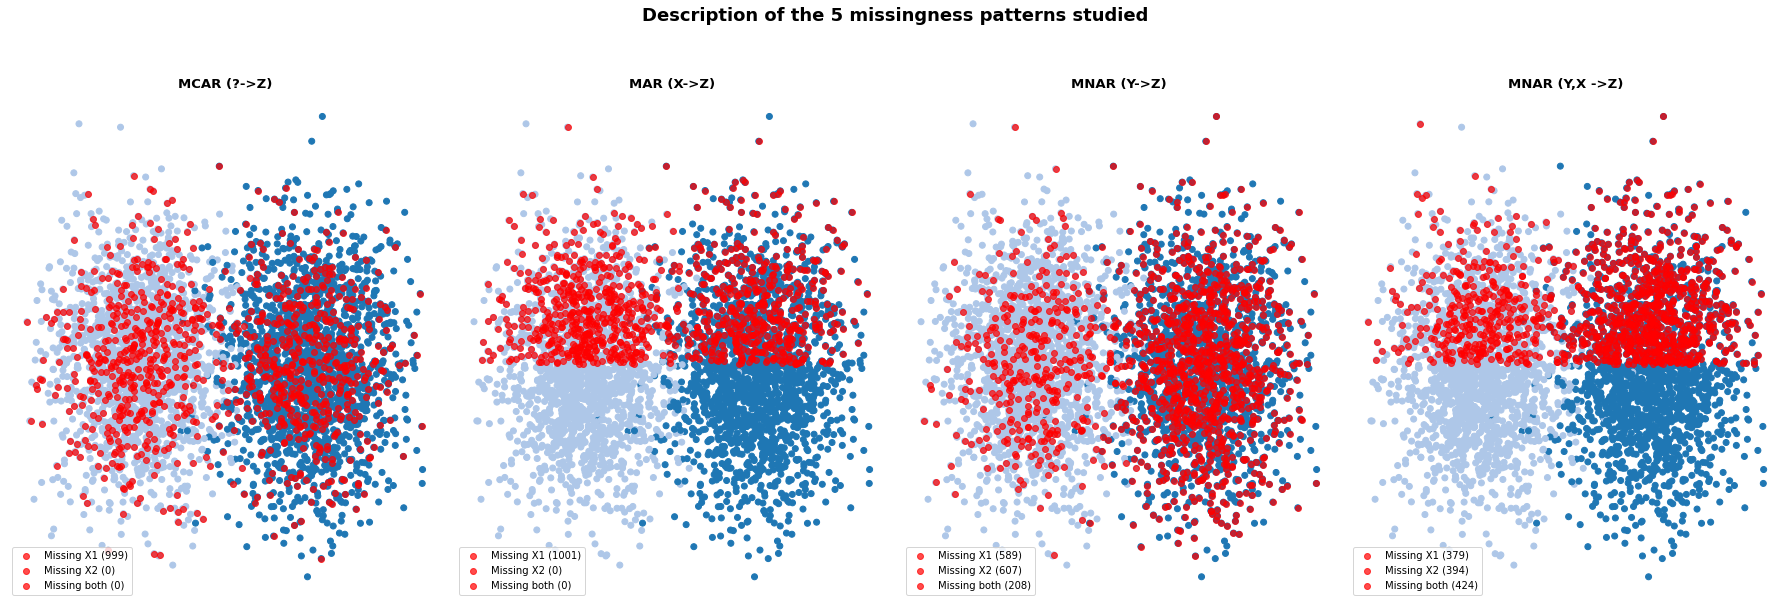

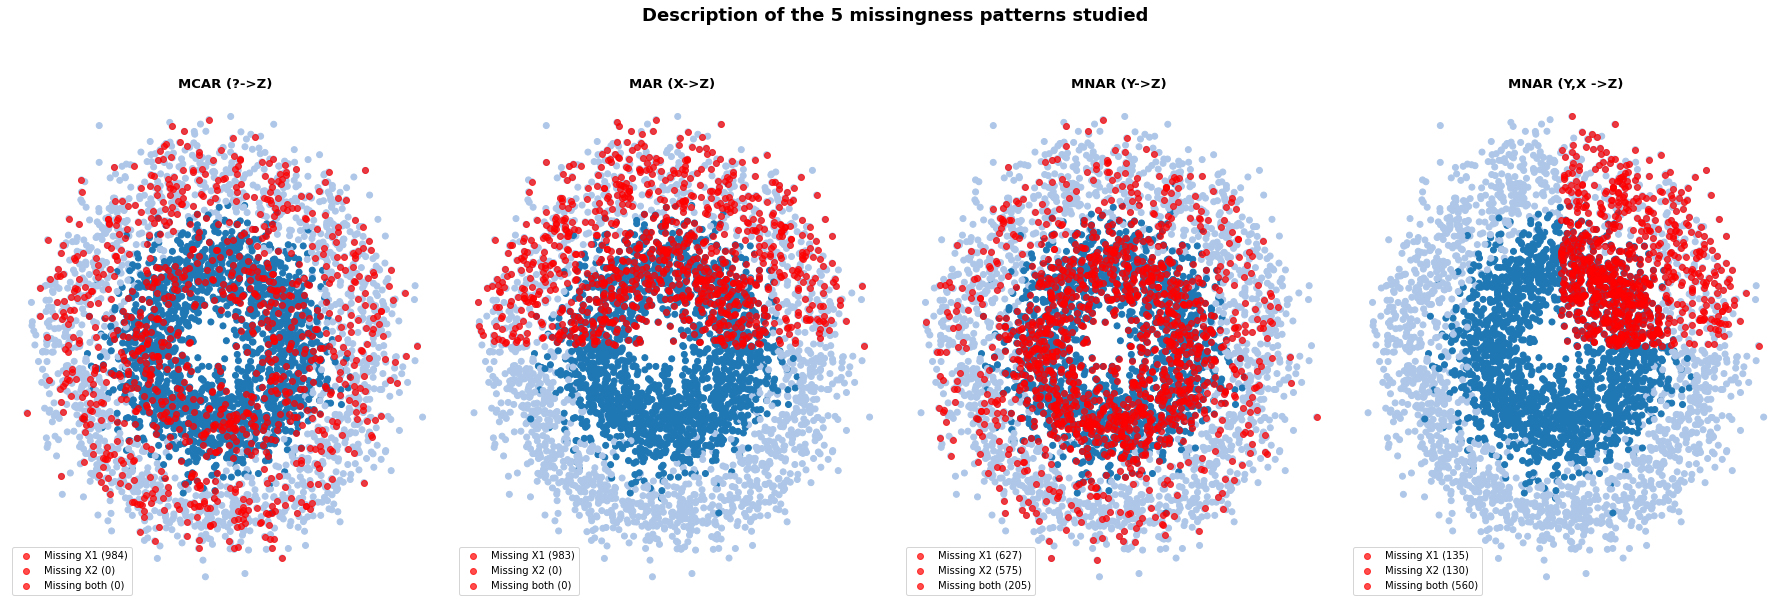

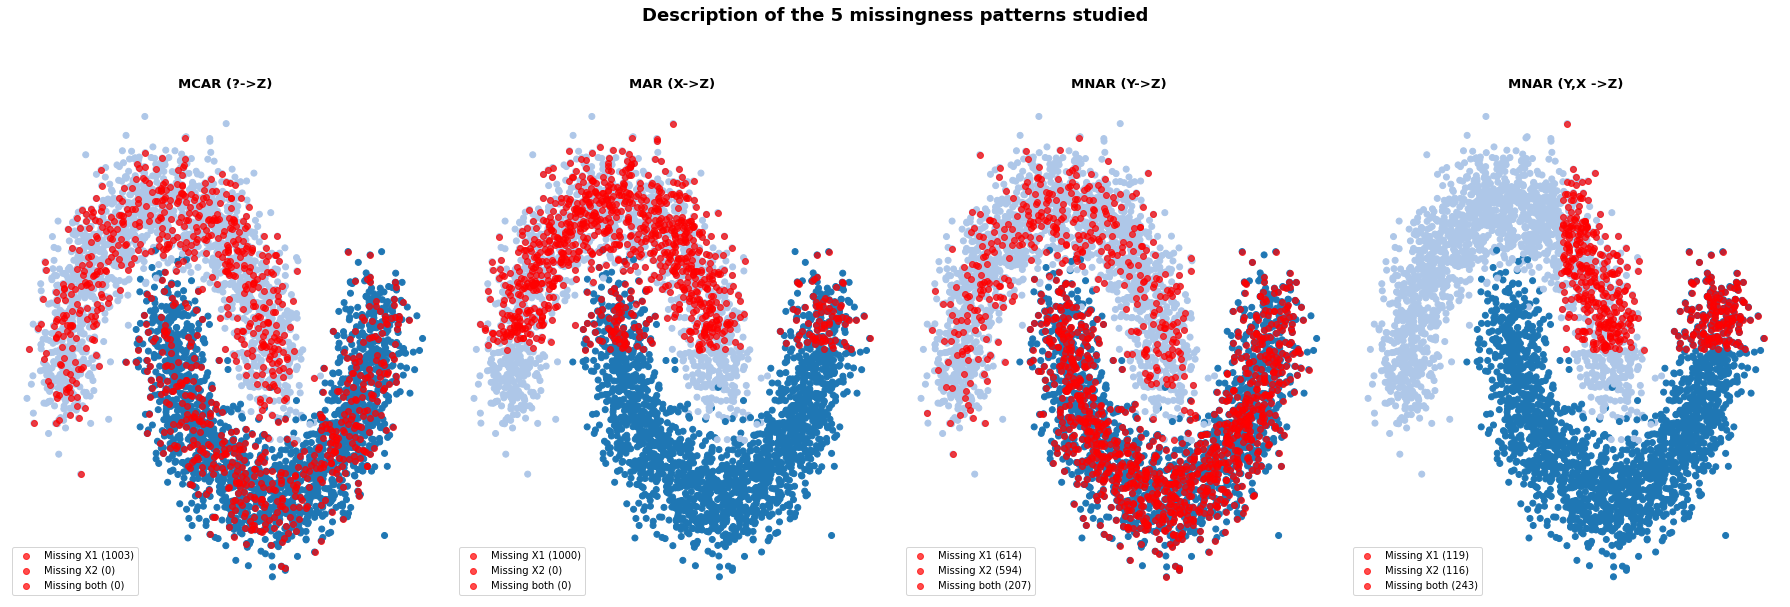

In [10]:
# Dataset default parameters
dataset_name = 'blobs'
num_samples = 5000
imbalance_ratio = .5
ratio_of_missing_values = .2
verbosity=0
missing_data_handling = MISSING_DATA_HANDLING
imputation_method = DEFAULT_IMPUTATION_METHOD

for dataset_name in ['blobs', 'circles', 'moons']:
    
    dataset = DatasetGenerator(dataset_name=dataset_name, 
                        num_samples=num_samples, 
                        imbalance_ratio=imbalance_ratio, 
                        missing_data_handling=missing_data_handling,
                        imputation_method=imputation_method,
                        verbosity=verbosity)
    dataset.split_test_train()

    fig, axes = plt.subplots(1, 4, figsize=(25, 8));axes = axes.flatten()
    fig.suptitle("Description of the 5 missingness patterns studied", y=1.05, fontsize=18, weight='bold')

    for i, missingness_pattern in enumerate([1, 3, 4, 5]):

        # Creation of the missingness
        dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern)
        axes[i], _  = dataset.plot(ax1=axes[i], ax2=None)
        axes[i].set_title(DICT_MISSINGNESS[missingness_pattern], weight='bold')
    [axes[i].axis('off') for i in range(len(axes))]; plt.tight_layout()
    
    

# Introduction - Dataset definition

In [117]:
# Dataset default parameters
dataset_name = 'blobs'
num_samples = 5000
imbalance_ratio = .5

# Missingness default parameters
missingness_pattern = 5
ratio_of_missing_values = None
ratio_missing_per_class = [.1, 0.3]
# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN
missing_data_handling = 'without'
imputation_method = 'without'
# VERBOSITY
verbosity=4

**Creation of the dataset**

Splitting dataset into test and train set.


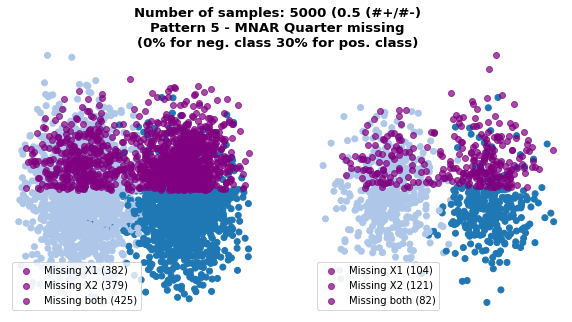

In [118]:
dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

_ = dataset.plot()

# `multi_ditributions` approach

In [ ]:
approach = 'multi_distributions'
missing_data_handling='without'
imputation_method='without'
use_missing_indicator_variables = False
resolution = 50

dataset.change_imputation_approach(missing_data_handling, imputation_method)
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=verbosity, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=resolution, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot(plot_points=False)
                        
                

MD handling: without (without) --> without (without), with changes of the data.


# `single_distribution` approach

In [ ]:
approach = 'single_distribution'
missing_data_handling='imputation'
imputation_method='multi_dimensional_weighting'
use_missing_indicator_variables = False
resolution = 50

dataset.change_imputation_approach(missing_data_handling, imputation_method)

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=1, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=resolution, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

In [ ]:
# Plot results
exp.plot(plot_points=False)

# `Neural Additive Networks` approach

In [ ]:
approach = 'nam'
missing_data_handling='encoding'
imputation_method='without'
use_missing_indicator_variables = False

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=0, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=20, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()
                        
                

# `Explanable Boosting Machine` approach

Encoding 4000 (train) and 1000 (test) missing values with -5.


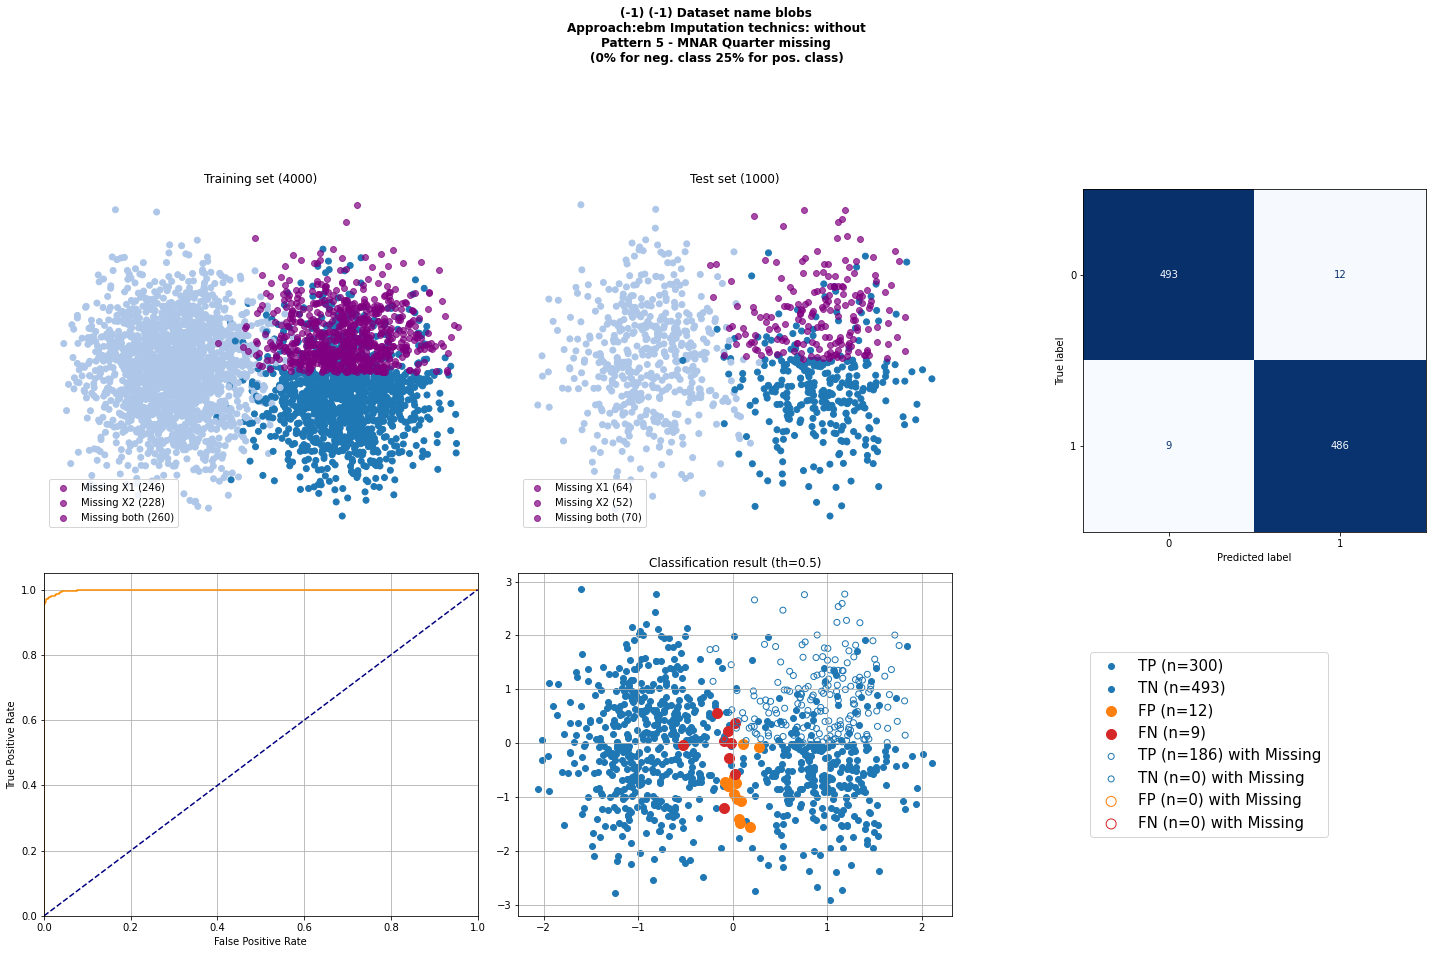

<!-- http://127.0.0.1:7001/139689789173200/ -->

In [11]:
approach = 'ebm'
missing_data_handling='encoding'
imputation_method='without'
use_missing_indicator_variables = False

# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=0, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=20, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()
                        
                

In [13]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
ebm_global = exp.model.explain_global()

show(ebm_global)

<!-- http://127.0.0.1:7001/139688740765264/ -->

# `Logistic Regression` approach

Splitting dataset into test and train set.
Encoding 4000 (train) and 1000 (test) missing values with -5.
Encoding 4000 (train) and 1000 (test) missing values with -5.


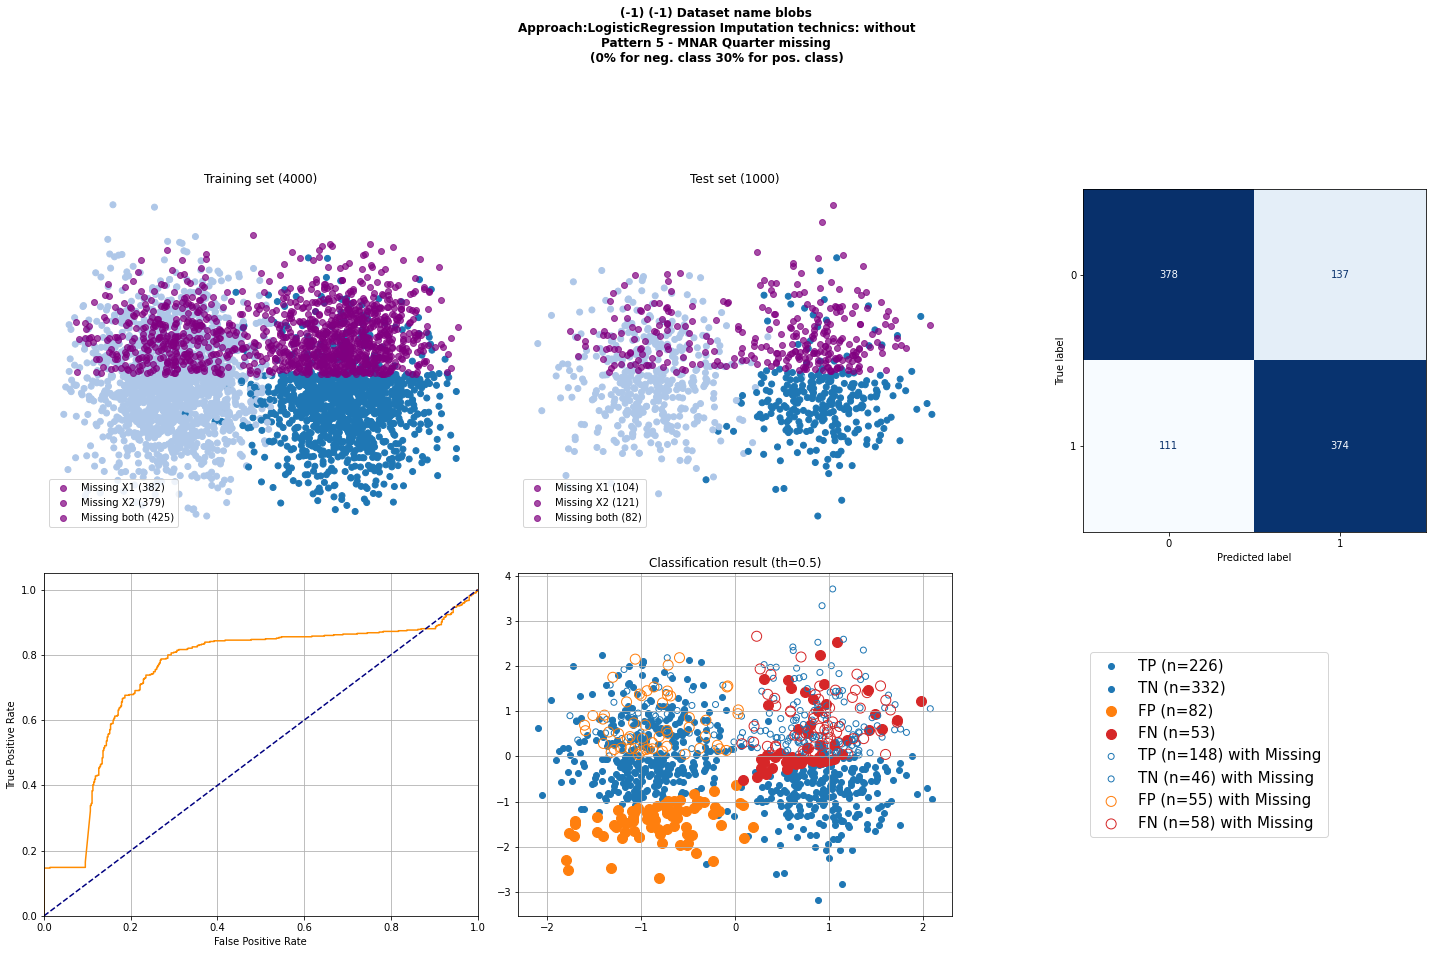

Not implemented yet.
Encoding 4000 (train) and 1000 (test) missing values with -5.


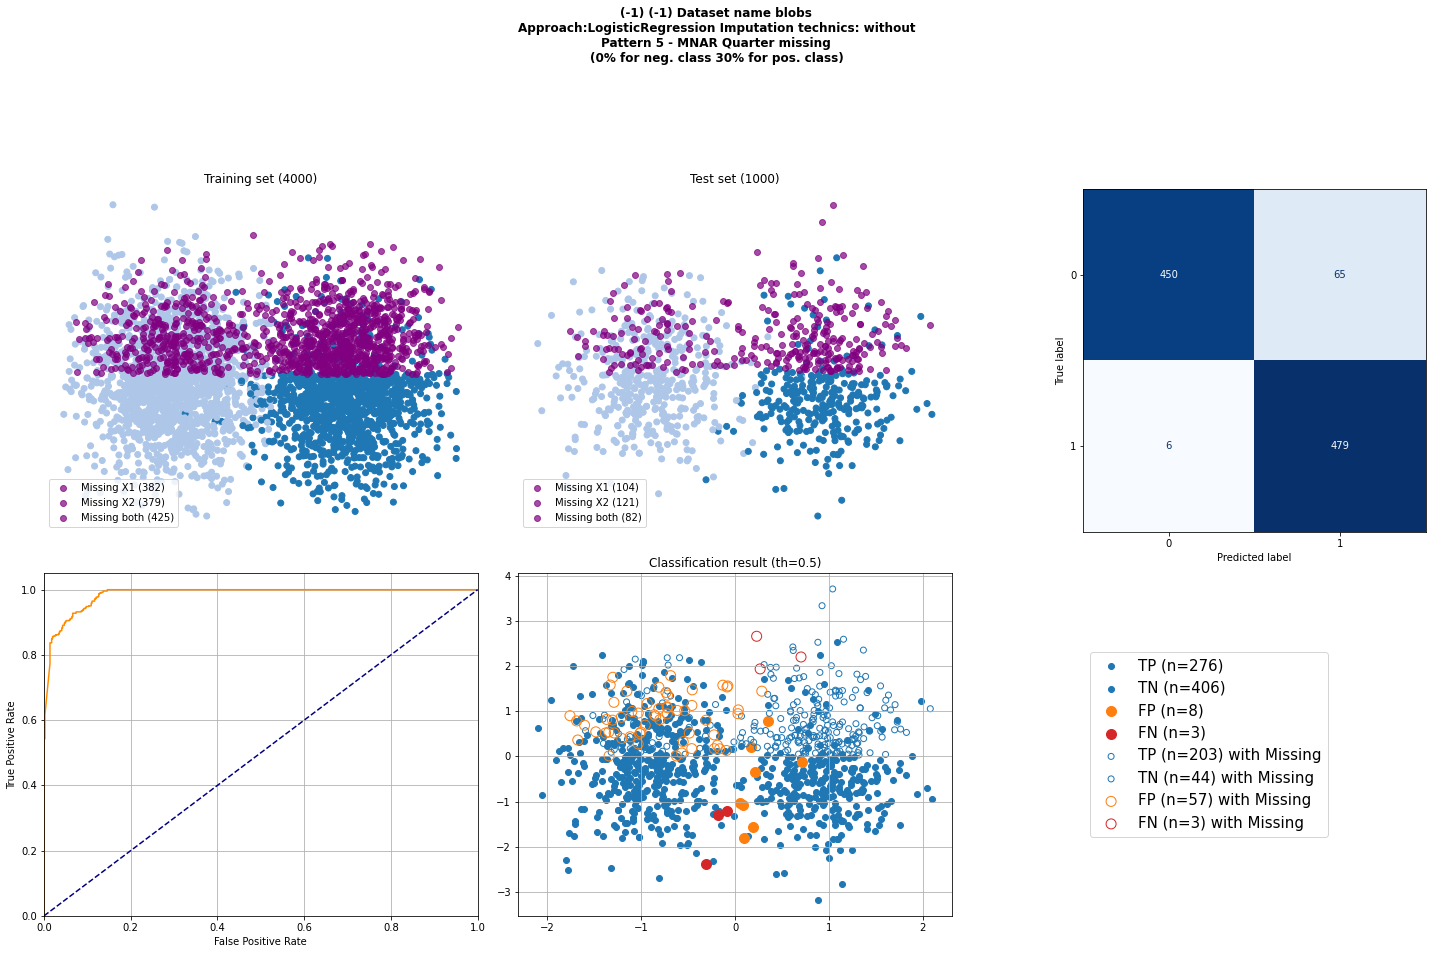

Not implemented yet.


In [85]:
approach = 'LogisticRegression'
missing_data_handling='encoding'
imputation_method='without'
use_missing_indicator_variables = False

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

for use_missing_indicator_variables in [False, True]:

    # Create the experiments
    exp = Experiments(dataset_name, 
                      dataset=dataset, 
                      purpose='classification', 
                      approach = approach, 
                      use_missing_indicator_variables=use_missing_indicator_variables,
                      previous_experiment=None, 
                      save_experiment=False, 
                      verbosity=0, 
                      debug=False, 
                      proportion_train=PROPORTION_TRAIN, 
                      resolution=20, 
                      bandwidth=BANDWIDTH,
                      random_state=RANDOM_STATE)


    # Estimate the distributions 
    exp.fit()

    # Estimate the distributions 
    exp.predict()

    # Plot results
    exp.plot()



# `DecisionTree` approach

Splitting dataset into test and train set.
Encoding 4000 (train) and 1000 (test) missing values with -5.
Encoding 4000 (train) and 1000 (test) missing values with -5.


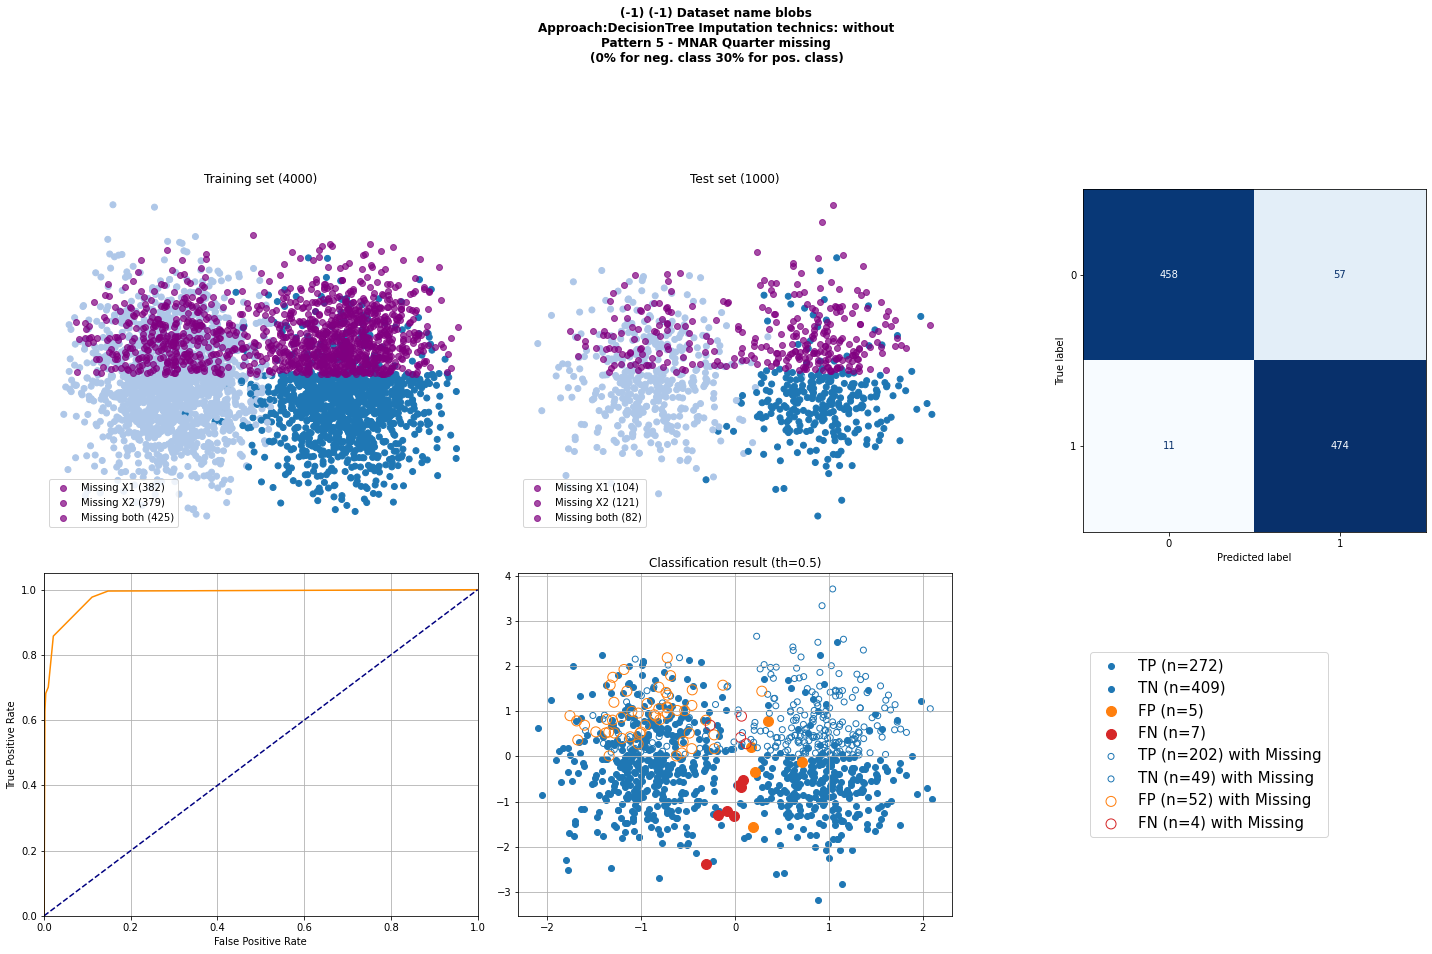

Not implemented yet.


In [87]:
approach = 'DecisionTree'
missing_data_handling='encoding'
imputation_method='without'
use_missing_indicator_variables = False

dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()



# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  use_missing_indicator_variables=use_missing_indicator_variables,
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=0, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=20, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()



# `XGBoost` approach

In [110]:
approach = 'xgboost'
missing_data_handling='encoding'
imputation_method='without'
use_missing_indicator_variables = False


# Dataset default parameters
dataset_name = 'blobs'
num_samples = 5000
imbalance_ratio = .5

# Missingness default parameters
missingness_pattern = 5
ratio_of_missing_values = None
ratio_missing_per_class = [.1, 0.3]
# pdf estimation default parameters
resolution = RESOLUTION
bandwidth = BANDWIDTH

# Classification default parameters
proportion_train = PROPORTION_TRAIN
missing_data_handling = 'without'
imputation_method = 'without'
# VERBOSITY
verbosity=4


dataset = DatasetGenerator(dataset_name=dataset_name, 
                            num_samples=num_samples, 
                            imbalance_ratio=imbalance_ratio, 
                            missing_data_handling=missing_data_handling,
                            imputation_method=imputation_method,
                            verbosity=verbosity)

# Creation of the missingness
dataset.generate_missing_coordinates(missingness_pattern=missingness_pattern, ratio_of_missing_values=ratio_of_missing_values, ratio_missing_per_class=ratio_missing_per_class)

dataset.split_test_train()

Splitting dataset into test and train set.


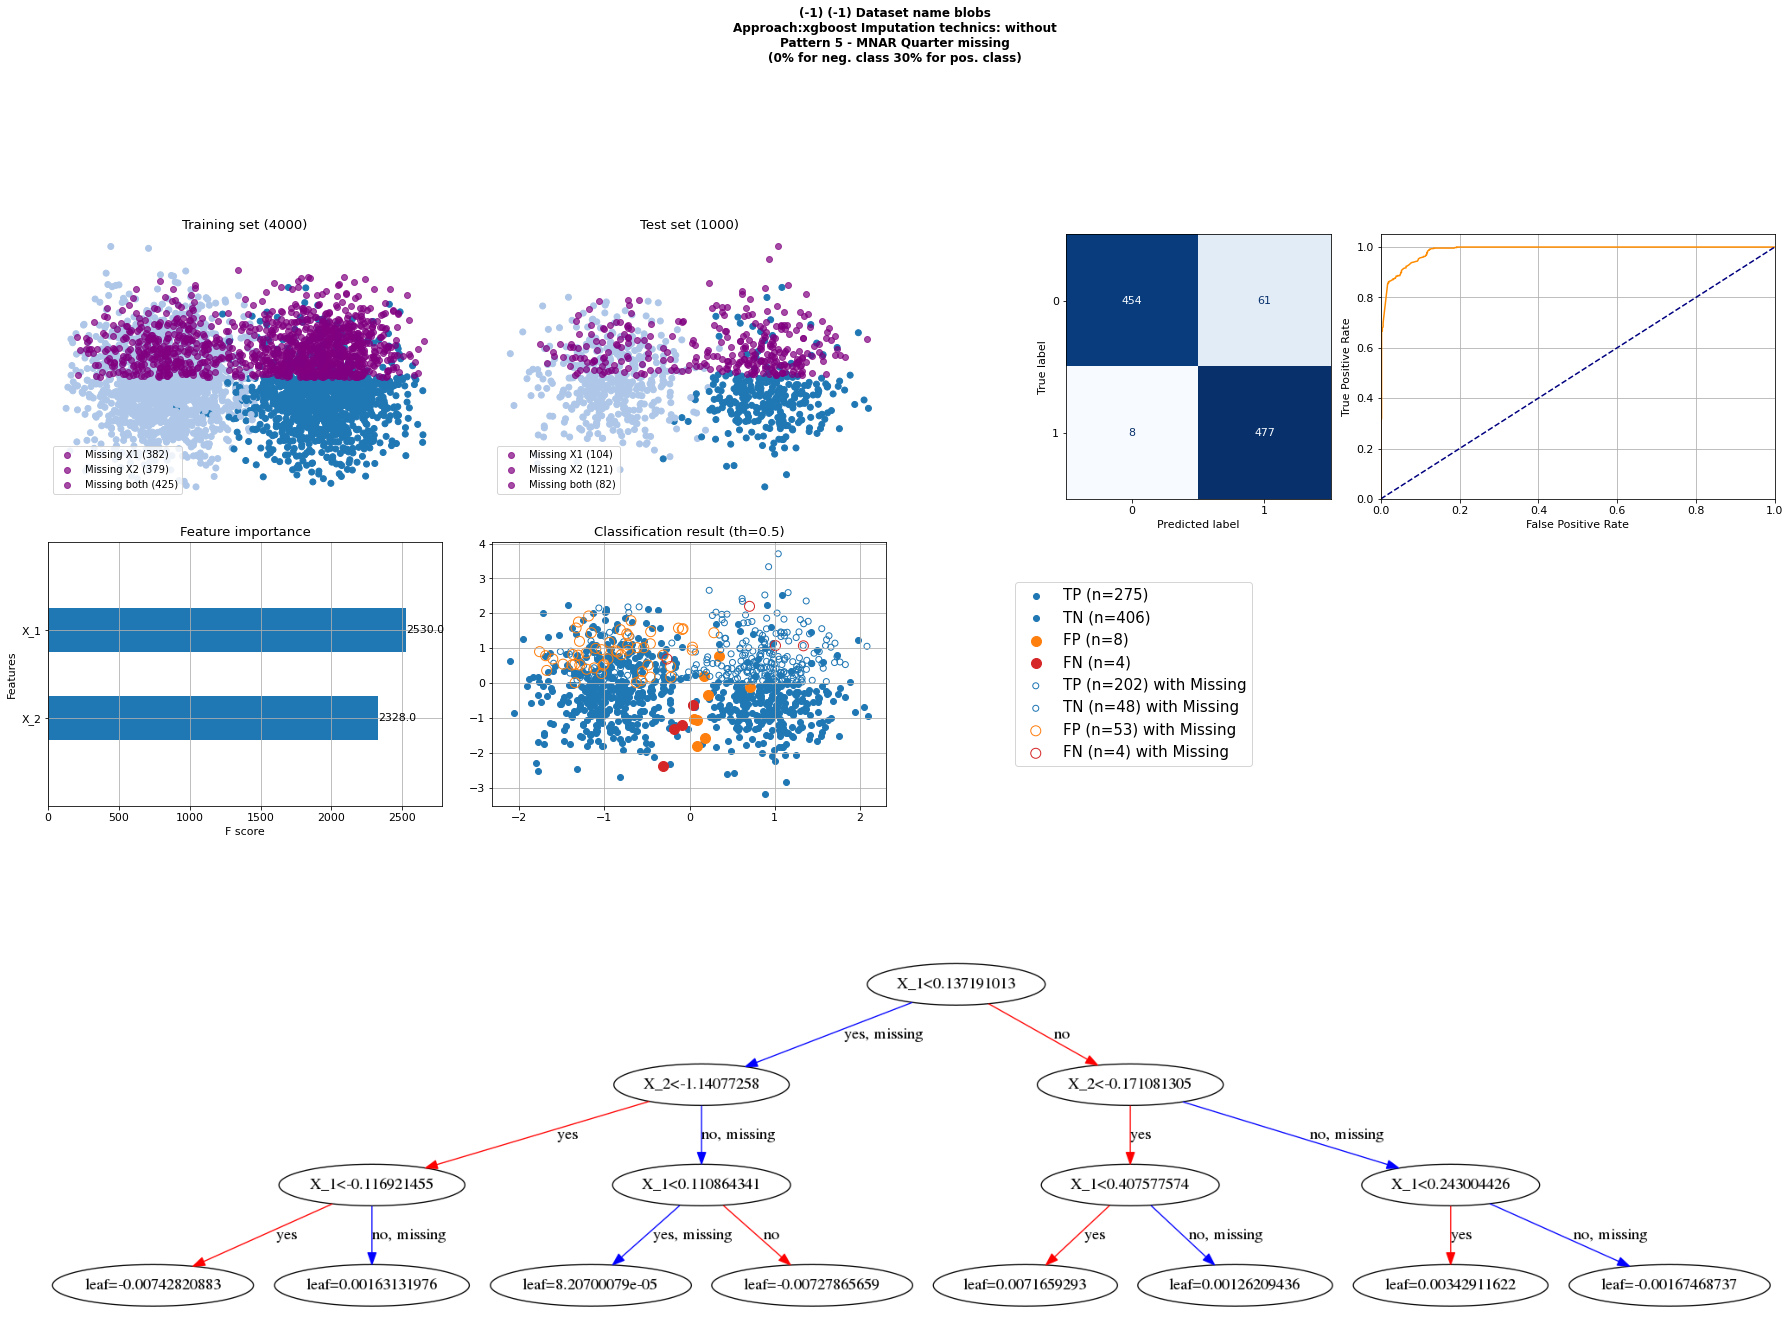

In [111]:
# Create the experiments
exp = Experiments(dataset_name, 
                  dataset=dataset, 
                  purpose='classification', 
                  approach = approach, 
                  use_missing_indicator_variables=use_missing_indicator_variables,
                  previous_experiment=None, 
                  save_experiment=False, 
                  verbosity=0, 
                  debug=False, 
                  proportion_train=PROPORTION_TRAIN, 
                  resolution=20, 
                  bandwidth=BANDWIDTH,
                  random_state=RANDOM_STATE)


# Estimate the distributions 
exp.fit()

# Estimate the distributions 
exp.predict()

# Plot results
exp.plot()

# Preliminary experiment 1: Which imputation method to use in the case of the single distribution ?

In [97]:
def check_unicity(df, x, hue):
    for _, f in df.groupby(by=[x, hue]):
        if len(f) > 1:
            display(f)
            return False
    return True

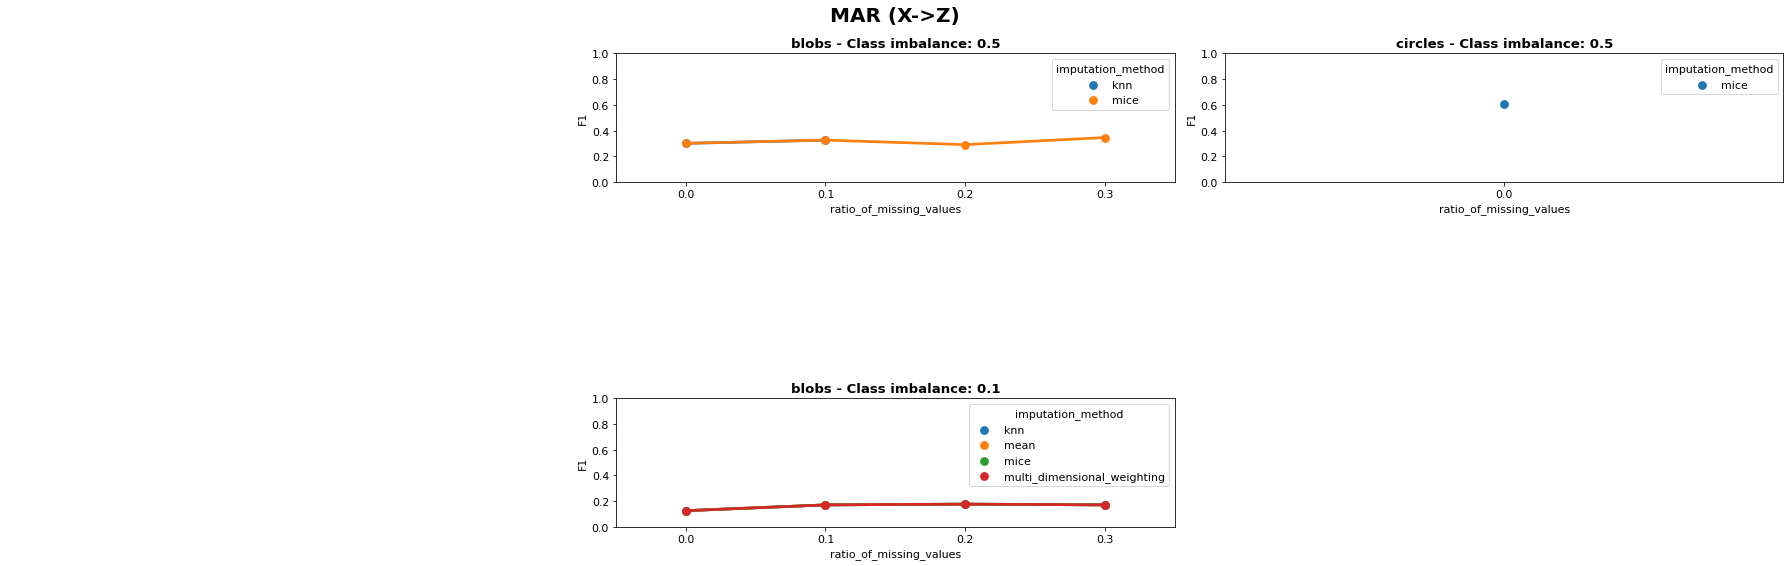

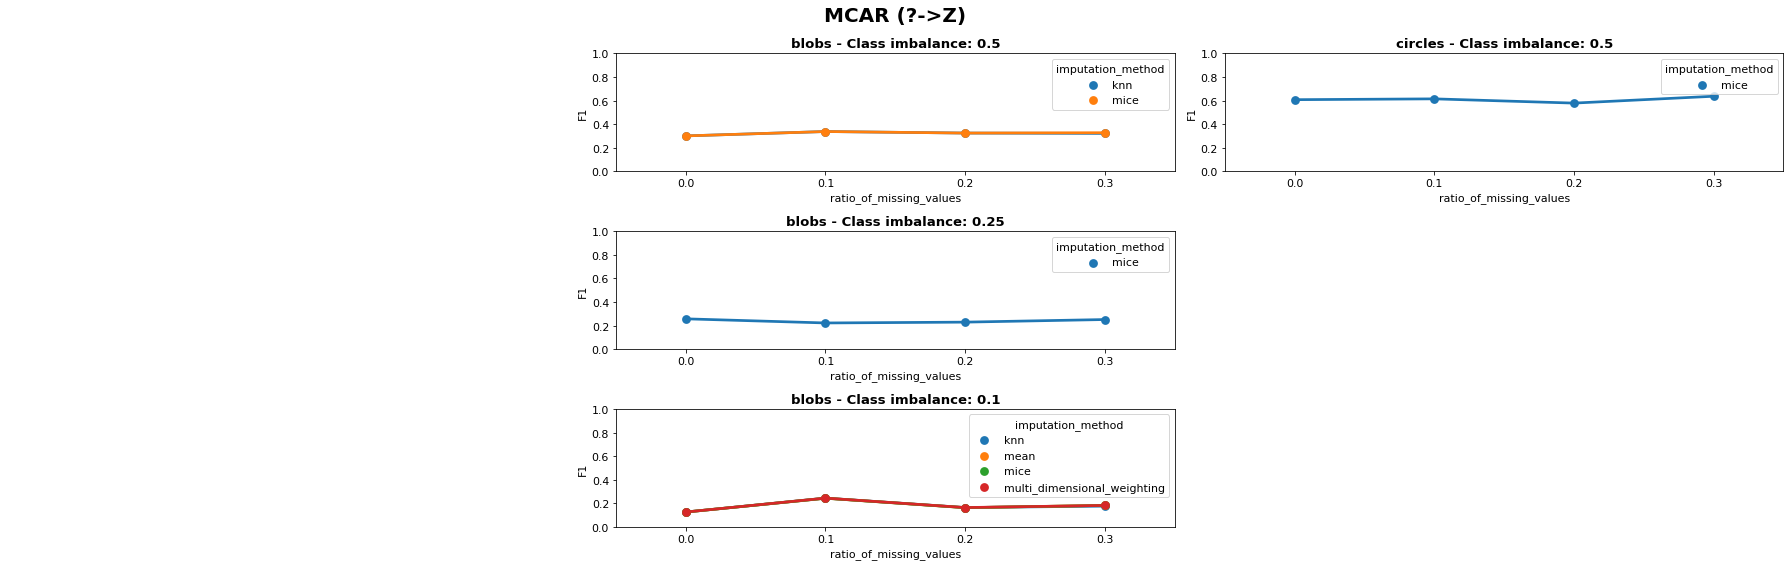

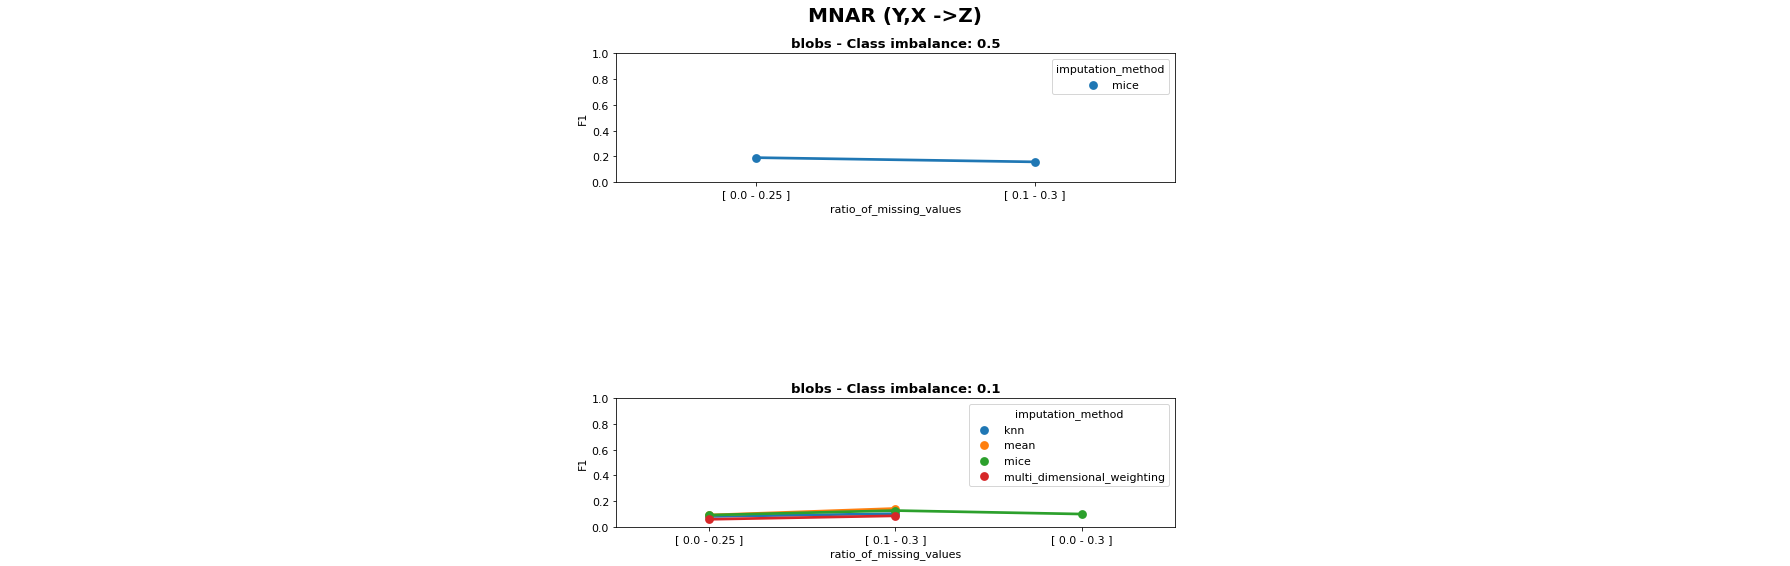

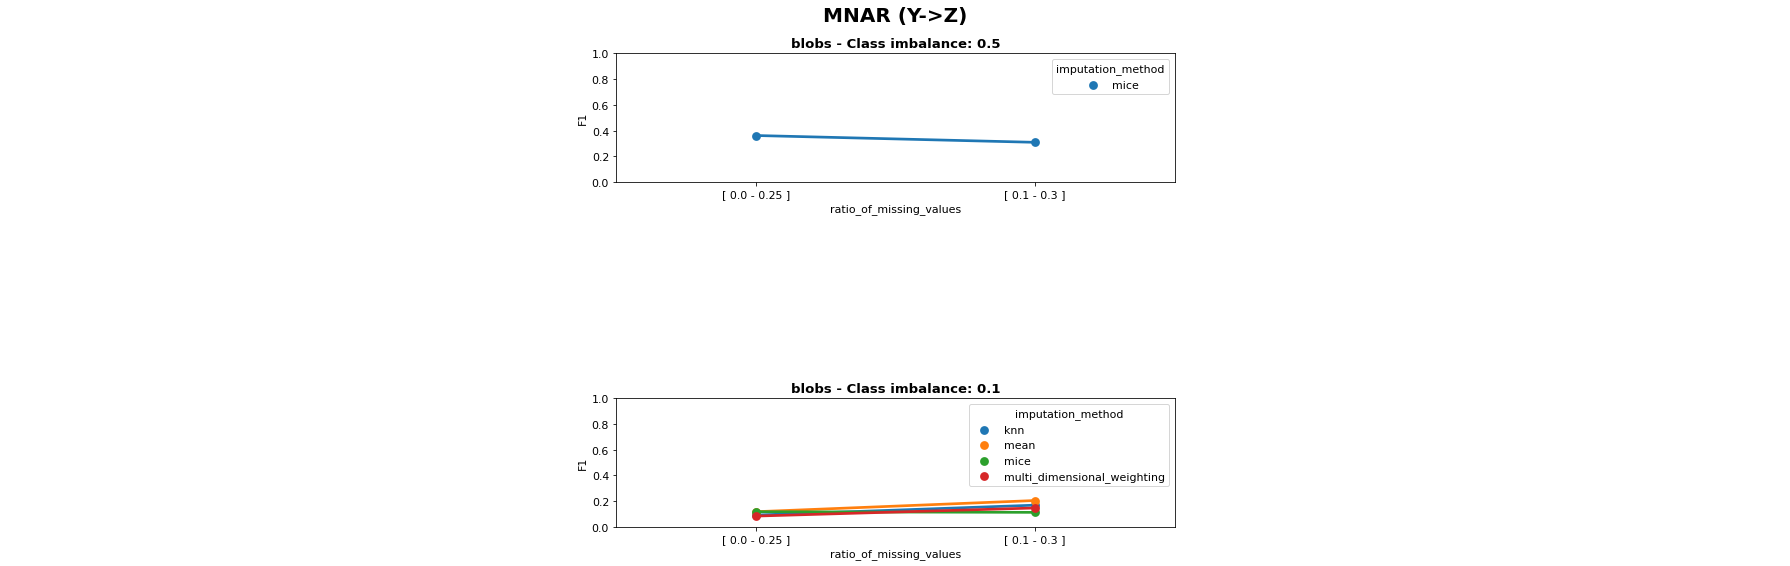

In [98]:


results = final_df[final_df['approach']== 'single_distribution']

x = 'ratio_of_missing_values'
hue = 'imputation_method'
    
    
for missingness_pattern in results['missingness_pattern'].unique():

    fig, axes = plt.subplots(3, 3, figsize=(25, 8))
    fig.suptitle(missingness_pattern, weight='bold', fontsize=20)

    for i, imbalance_ratio in enumerate(sorted(results['imbalance_ratio'].unique(), reverse=True)):

        for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):
        
            
            df = results[(results['imbalance_ratio']==imbalance_ratio) & (results['dataset_name']==dataset_name) & (results['missingness_pattern']==missingness_pattern)]

            assert check_unicity(df, x, hue)
            
            if len(df) > 0:

                axes[i][j] = sns.pointplot(data=df, x="ratio_of_missing_values", y="F1", hue='imputation_method', ci=False, ax = axes[i][j])
                axes[i][j].set_ylim([0,1])
                axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
            else:
                axes[i][j].grid('off');axes[i][j].axis('off')

    plt.tight_layout()
    
    
    

# Preliminary experiment 2 : Using indicator variable or not ?

In [18]:
def check_unicity(df, x, hue):
    for _, f in df.groupby(by=[x, hue]):
        if len(f) > 1:
            display(f)
            return False
    return True

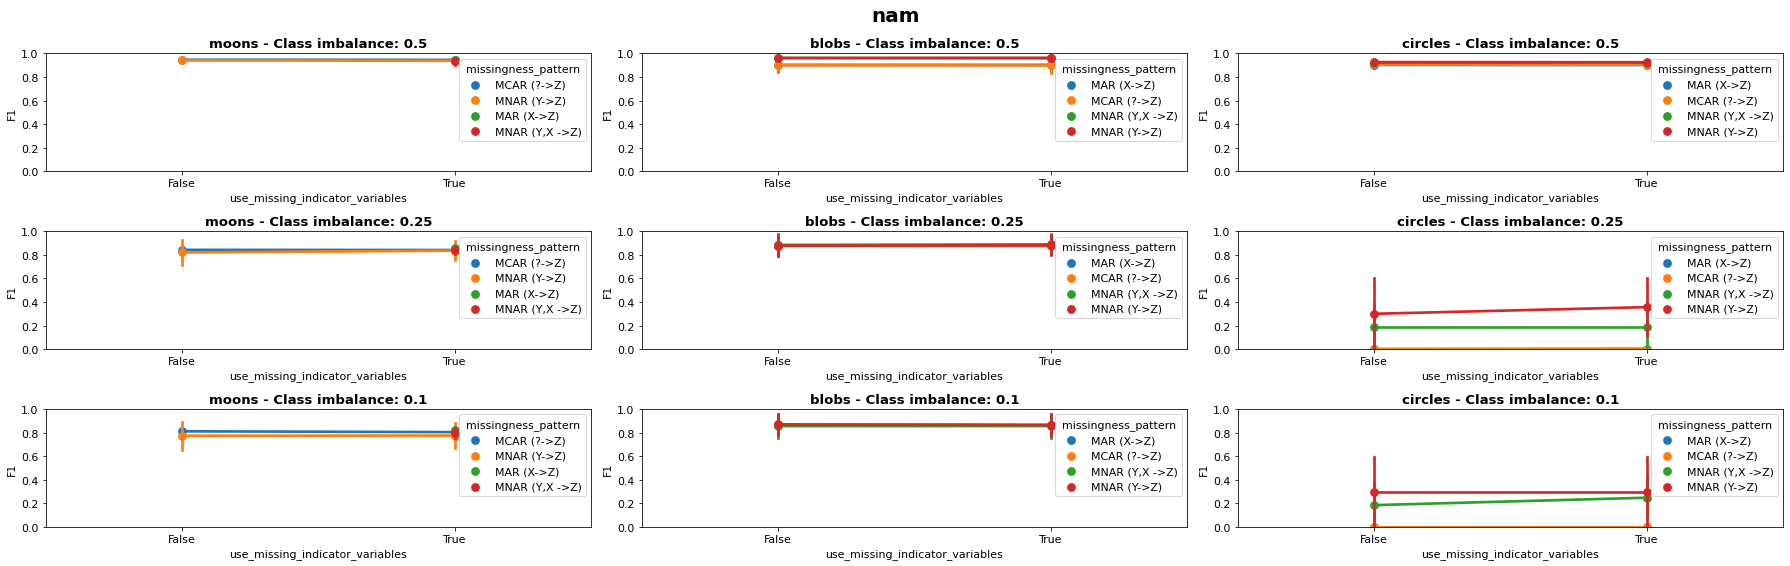

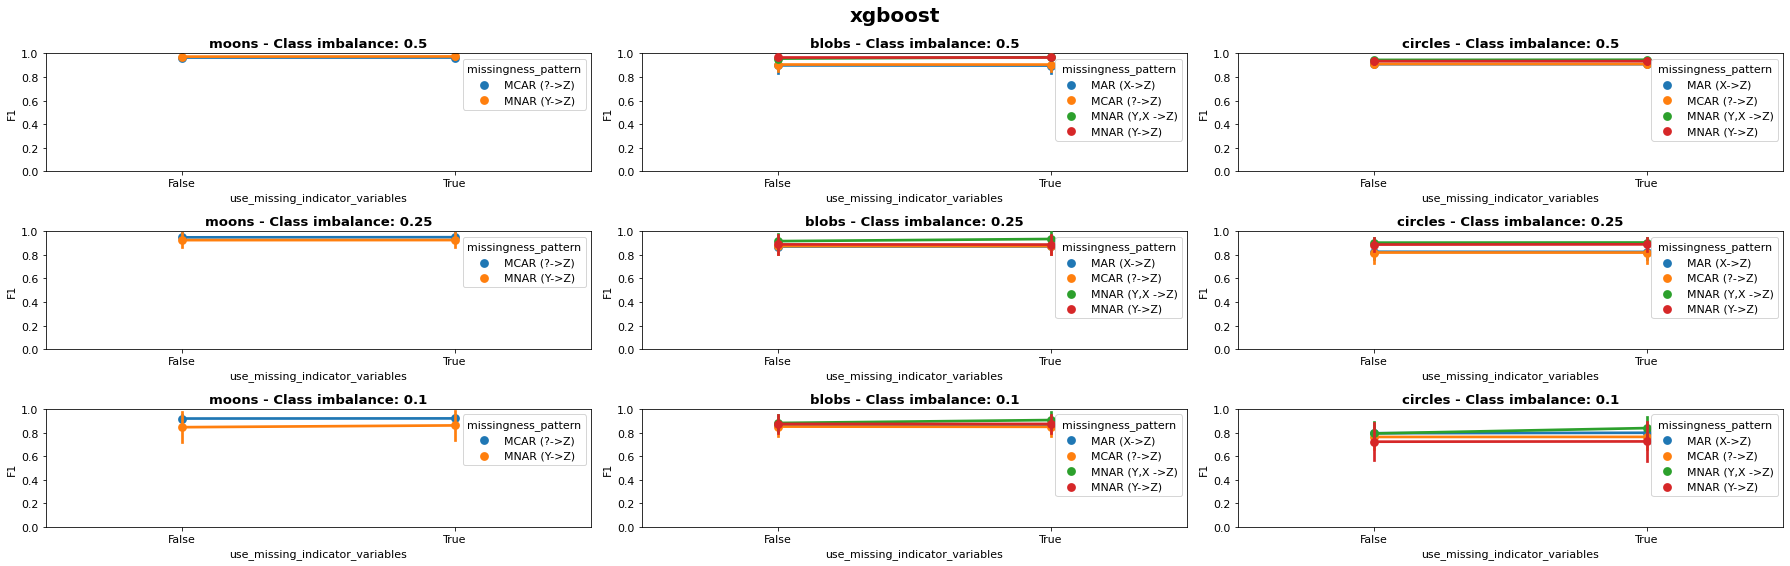

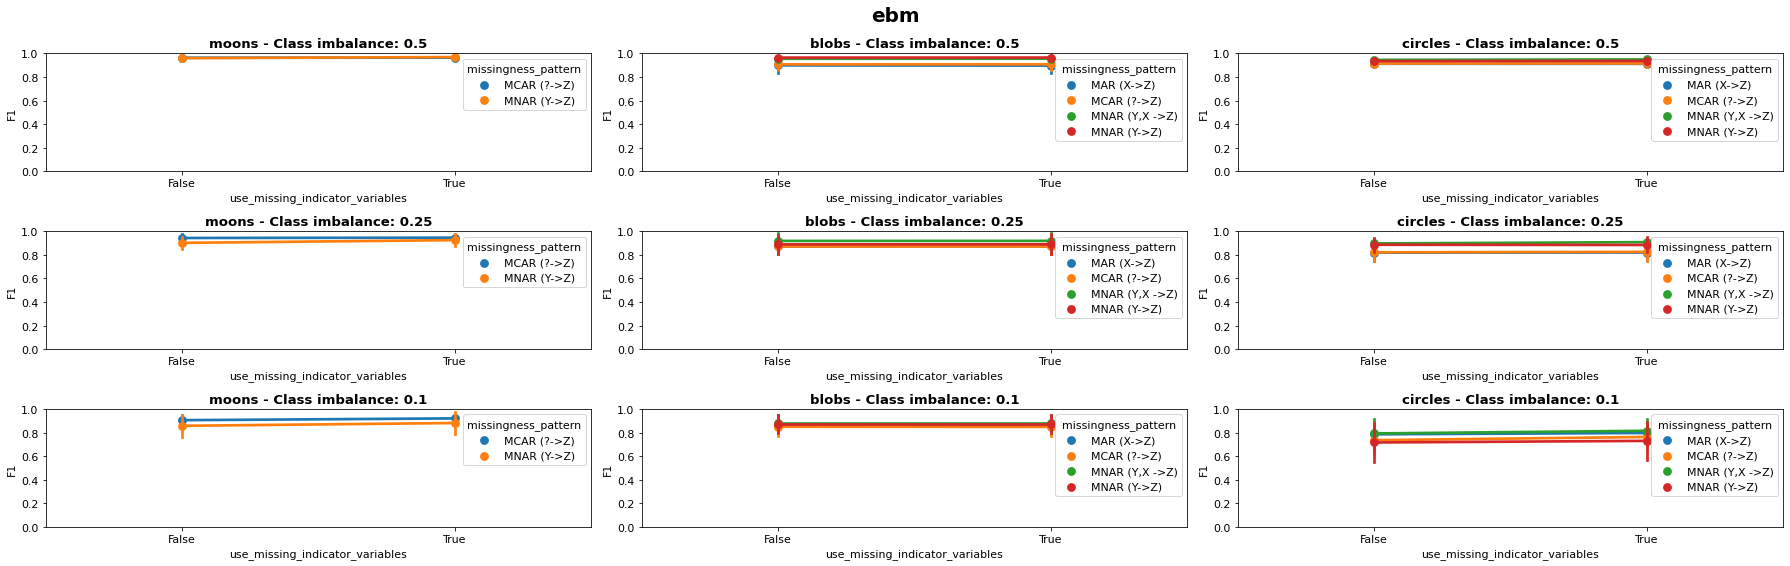

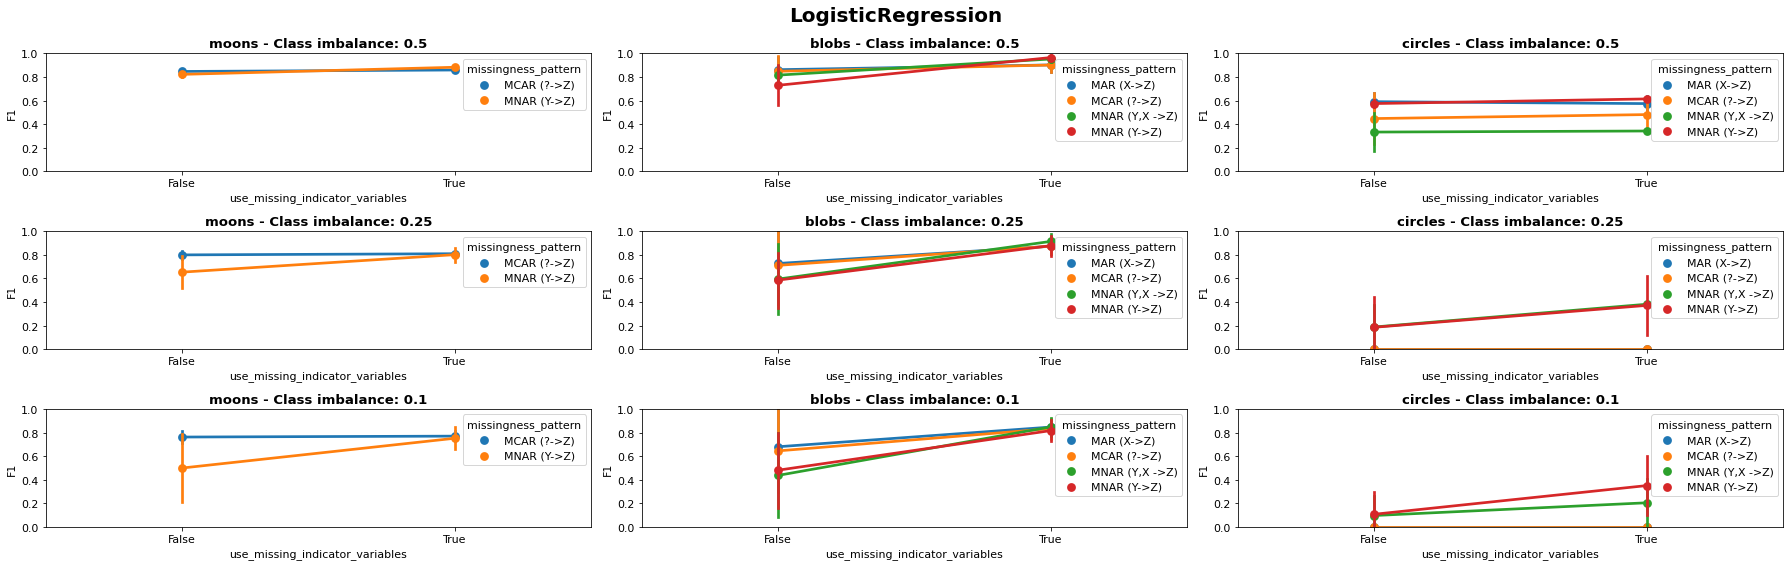

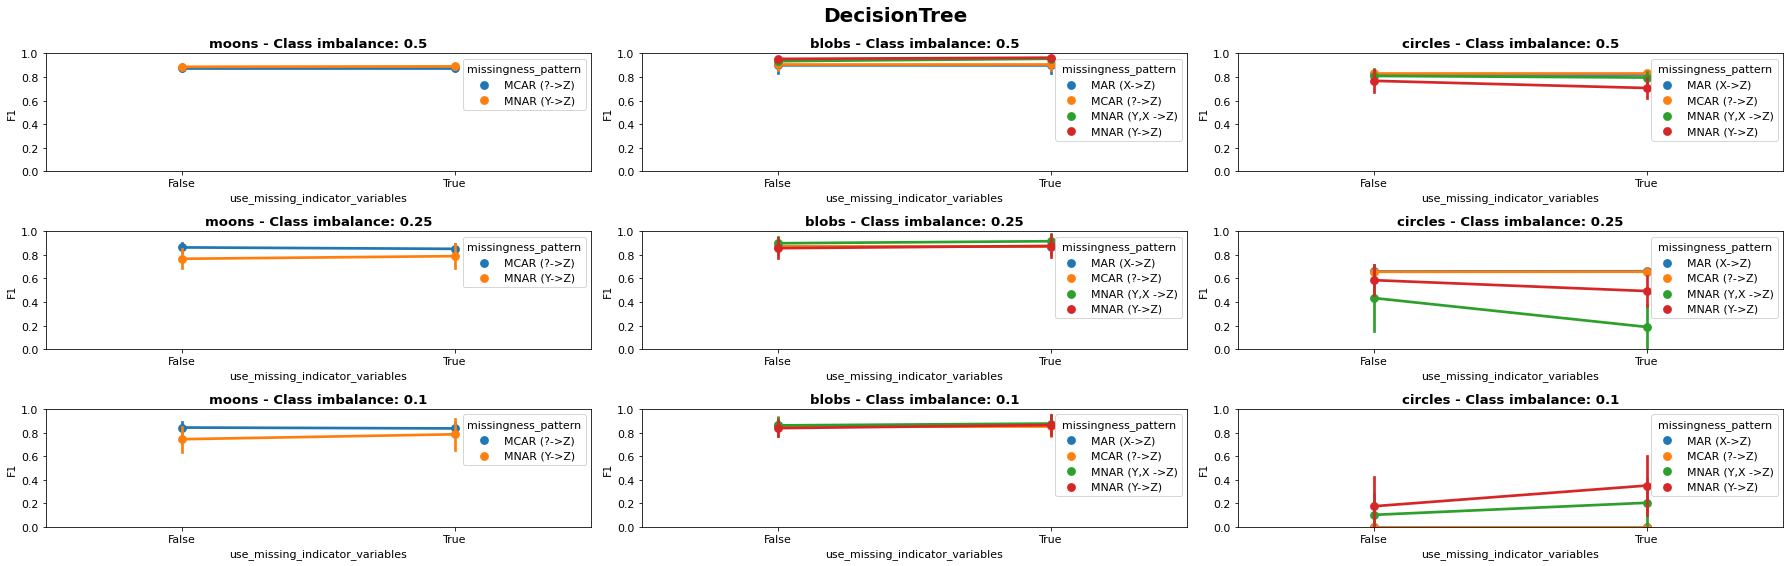

In [102]:
for approach in ['nam', 'xgboost', 'ebm', 'LogisticRegression', 'DecisionTree']:
    results = final_df[final_df['approach'] ==  approach]

    x = 'use_missing_indicator_variables'
    hue = 'missingness_pattern'


    fig, axes = plt.subplots(3, 3, figsize=(25, 8))
    fig.suptitle(approach, weight='bold', fontsize=20)

    for i, imbalance_ratio in enumerate(sorted(results['imbalance_ratio'].unique(), reverse=True)):

        for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):


            df = results[(results['imbalance_ratio']==imbalance_ratio) & (results['dataset_name']==dataset_name)]

            #assert check_unicity(df, x, hue)

            if len(df) > 0:

                axes[i][j] = sns.pointplot(data=df, x=x, y="F1", hue=hue, ci='sd', ax = axes[i][j])
                axes[i][j].set_ylim([0,1])
                axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
            else:
                axes[i][j].grid('off');axes[i][j].axis('off')

    plt.tight_layout()

**Does the importance improve when the ratio increases ?**

In [107]:
def check_unicity(df, x, hue):
    for _, f in df.groupby(by=[x, hue]):
        if len(f) > 1:
            display(f)
            return False
    return True

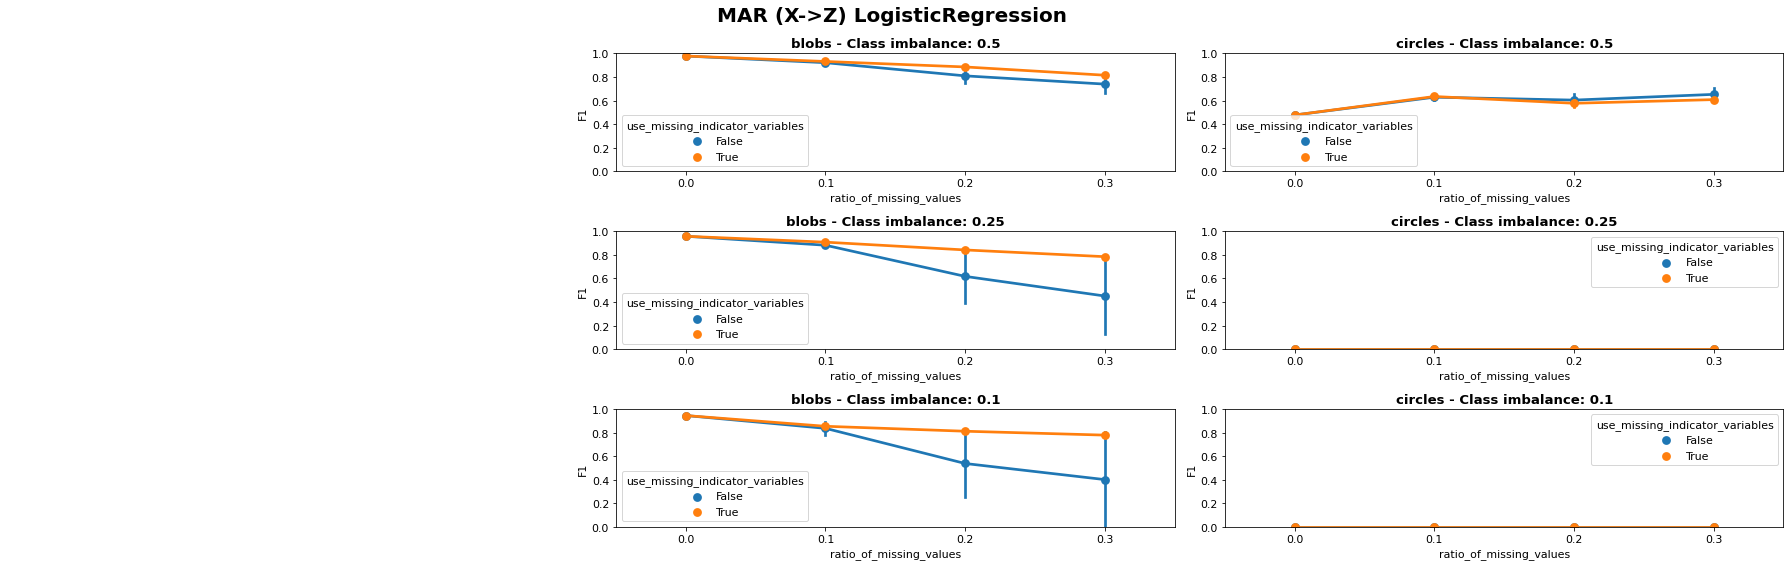

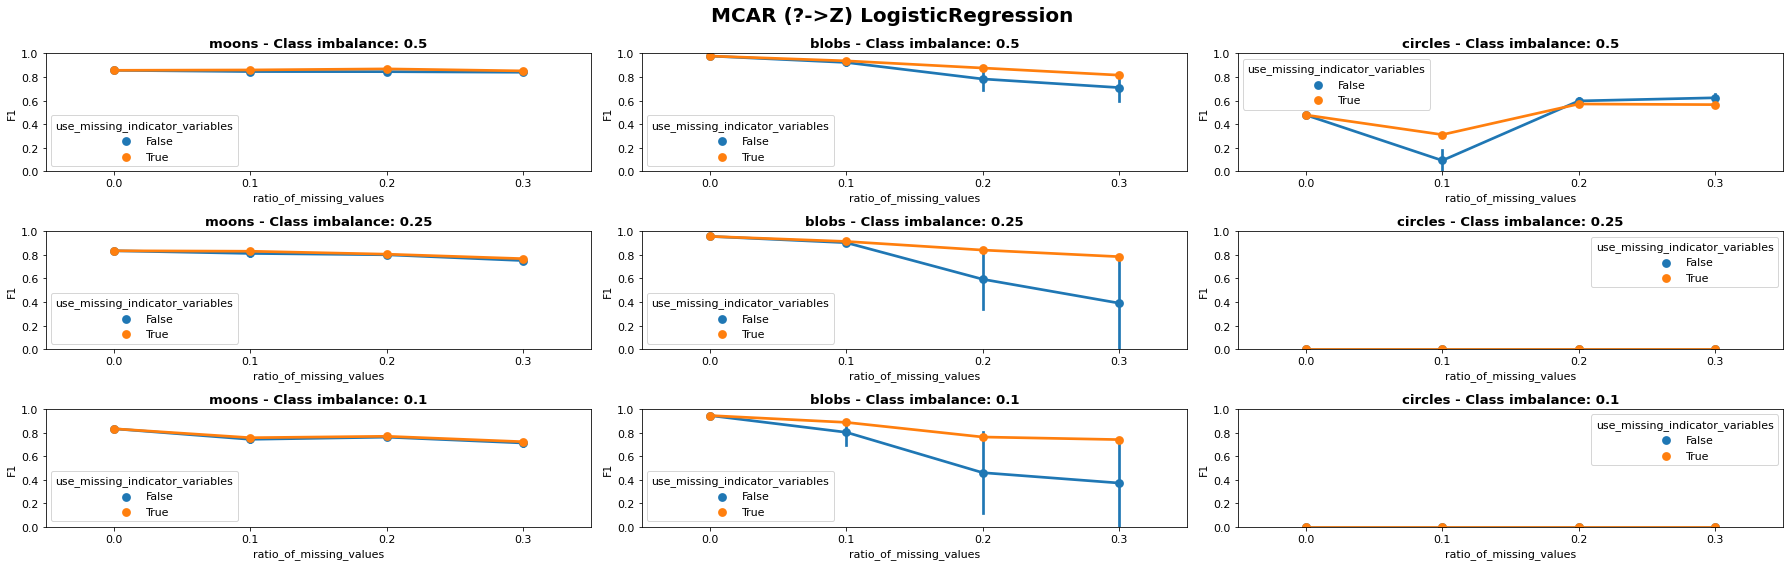

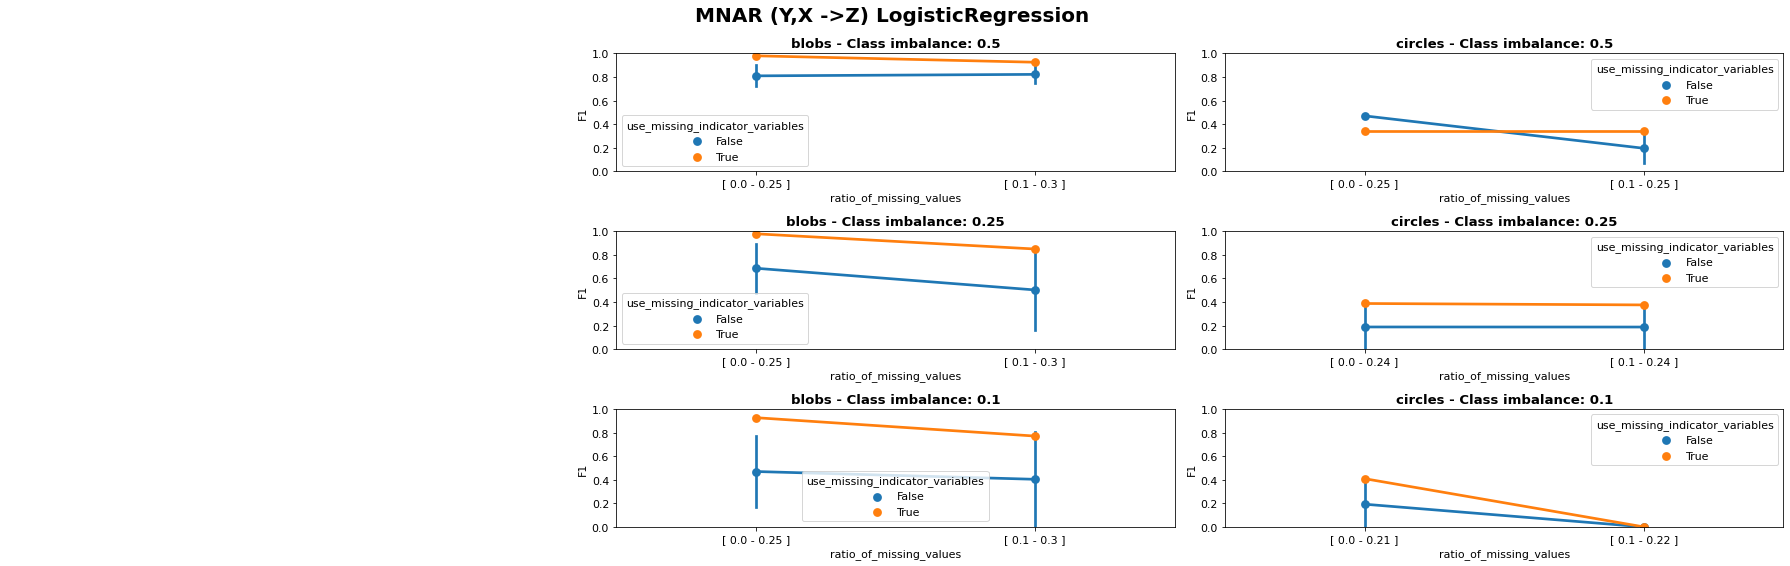

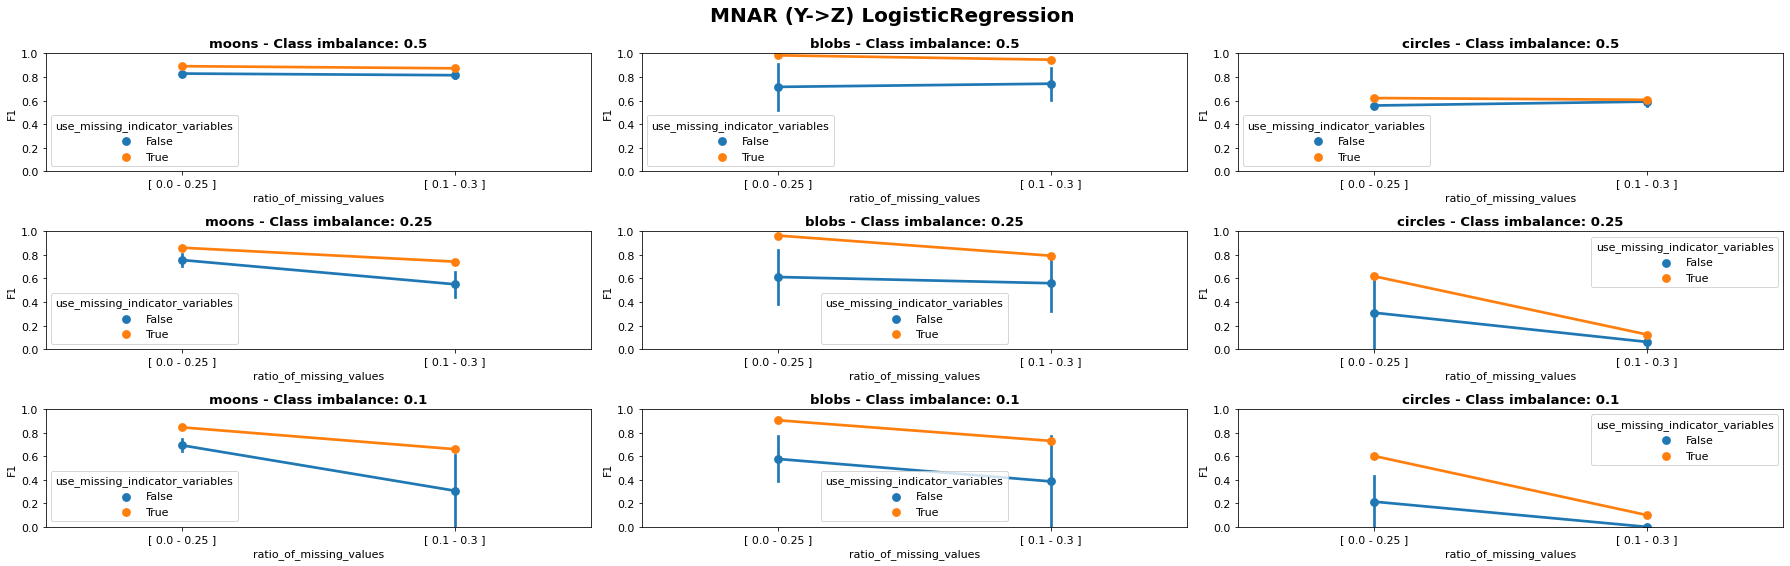

In [104]:
for approach in ['LogisticRegression']:
    for missingness_pattern in final_df['missingness_pattern'].unique():
        results = final_df[final_df['approach'] ==  approach]

        x = 'ratio_of_missing_values'
        hue = 'use_missing_indicator_variables'


        fig, axes = plt.subplots(3, 3, figsize=(25, 8))
        fig.suptitle("{} {} ".format(missingness_pattern,approach), weight='bold', fontsize=20)

        for i, imbalance_ratio in enumerate(sorted(results['imbalance_ratio'].unique(), reverse=True)):

            for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):


                df = results[(results['imbalance_ratio']==imbalance_ratio) & 
                             (results['dataset_name']==dataset_name) & 
                             (results['missingness_pattern']==missingness_pattern)]

                #assert check_unicity(df, x, hue)

                if len(df) > 0:

                    axes[i][j] = sns.pointplot(data=df, x=x, y="F1", hue=hue, ci='sd', ax = axes[i][j])
                    axes[i][j].set_ylim([0,1])
                    axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
                else:
                    axes[i][j].grid('off');axes[i][j].axis('off')

        plt.tight_layout()

# Preliminary experiment 3: Is it better to impute, encode, or do nothing (if relevant)? 

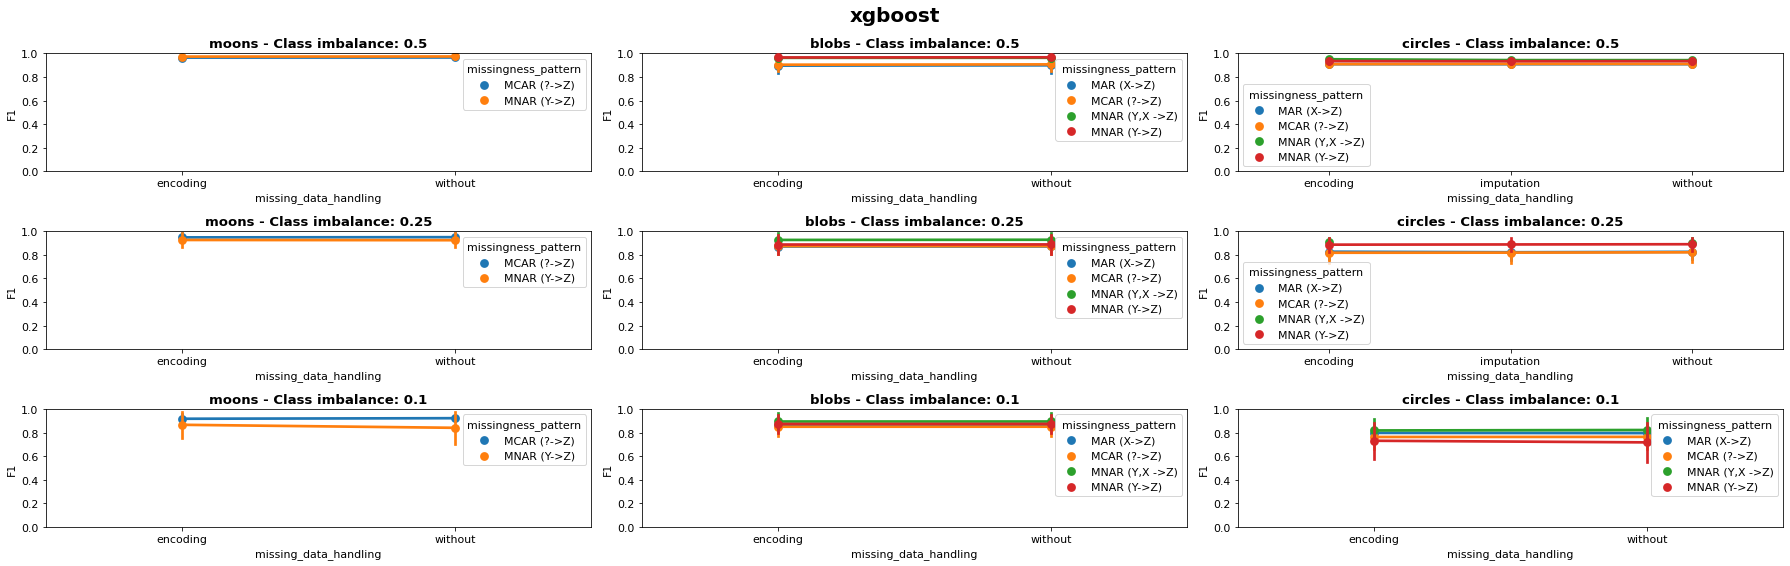

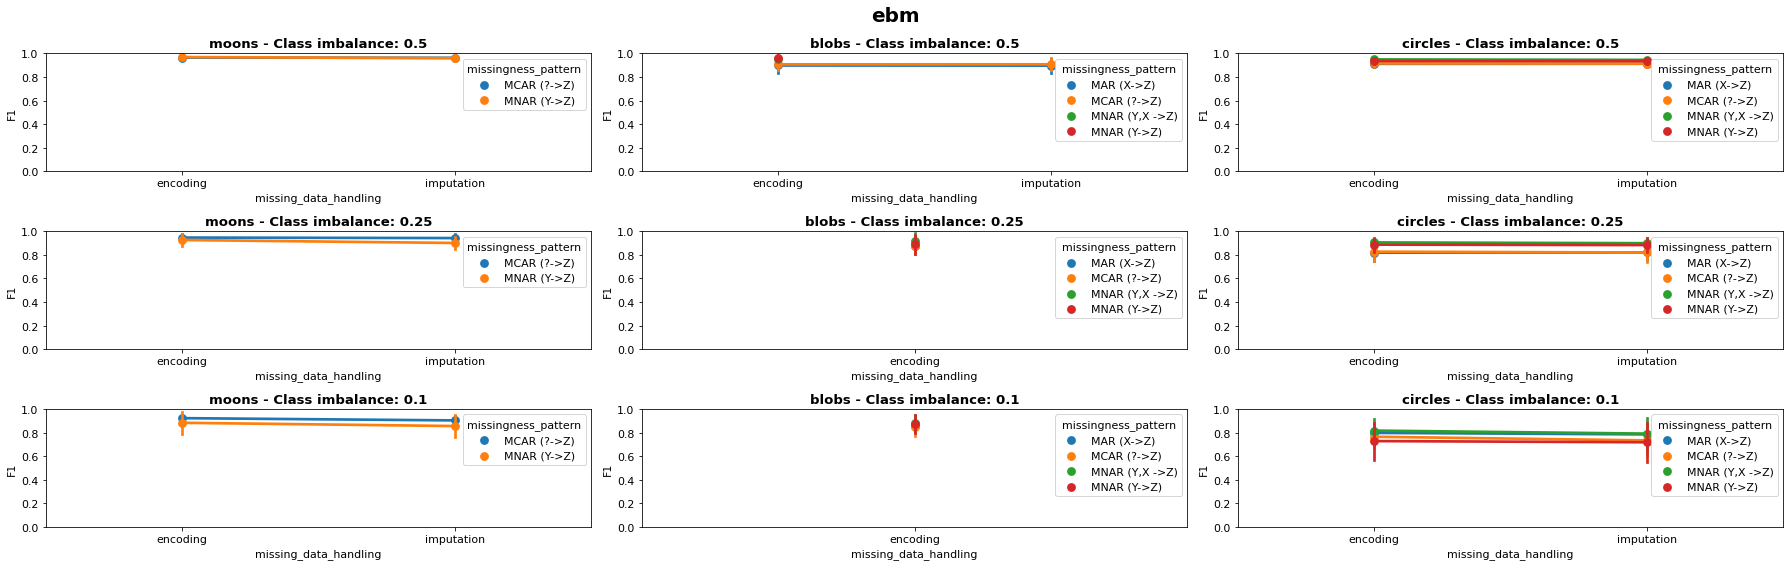

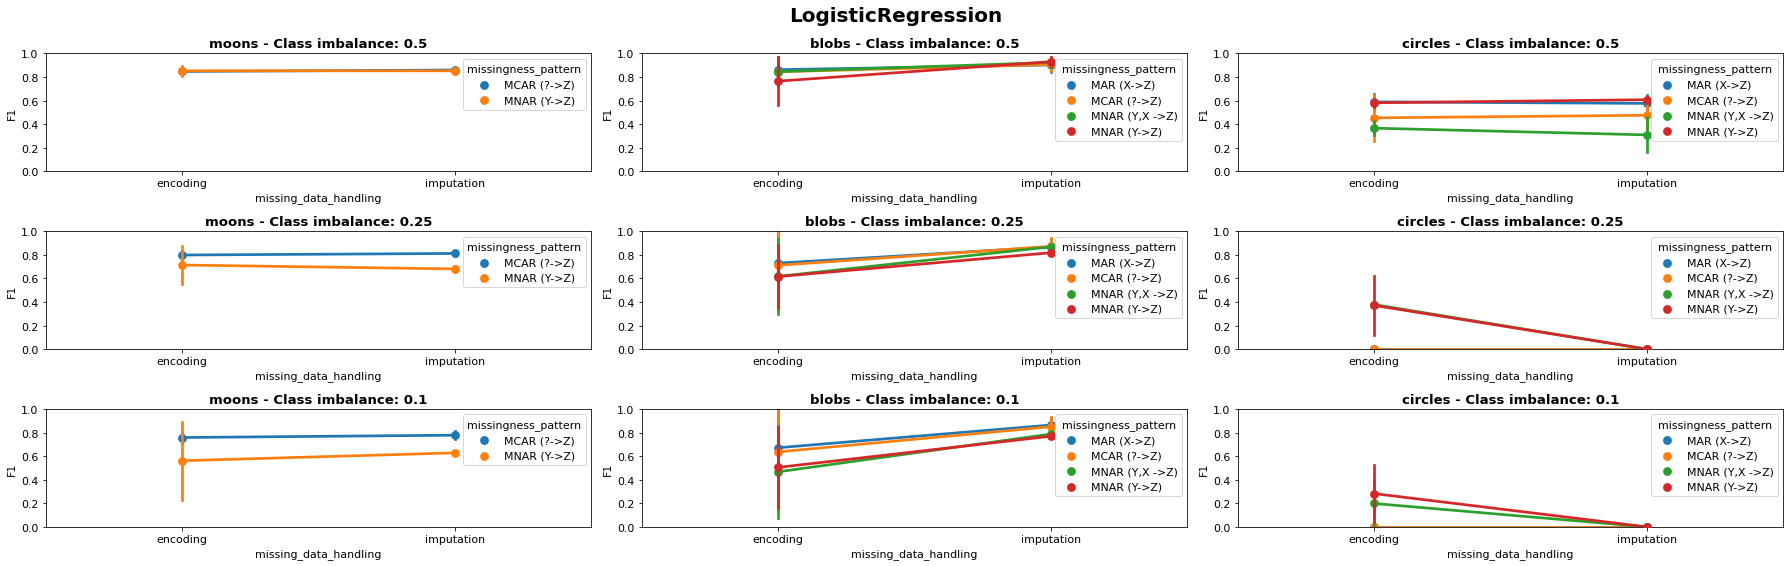

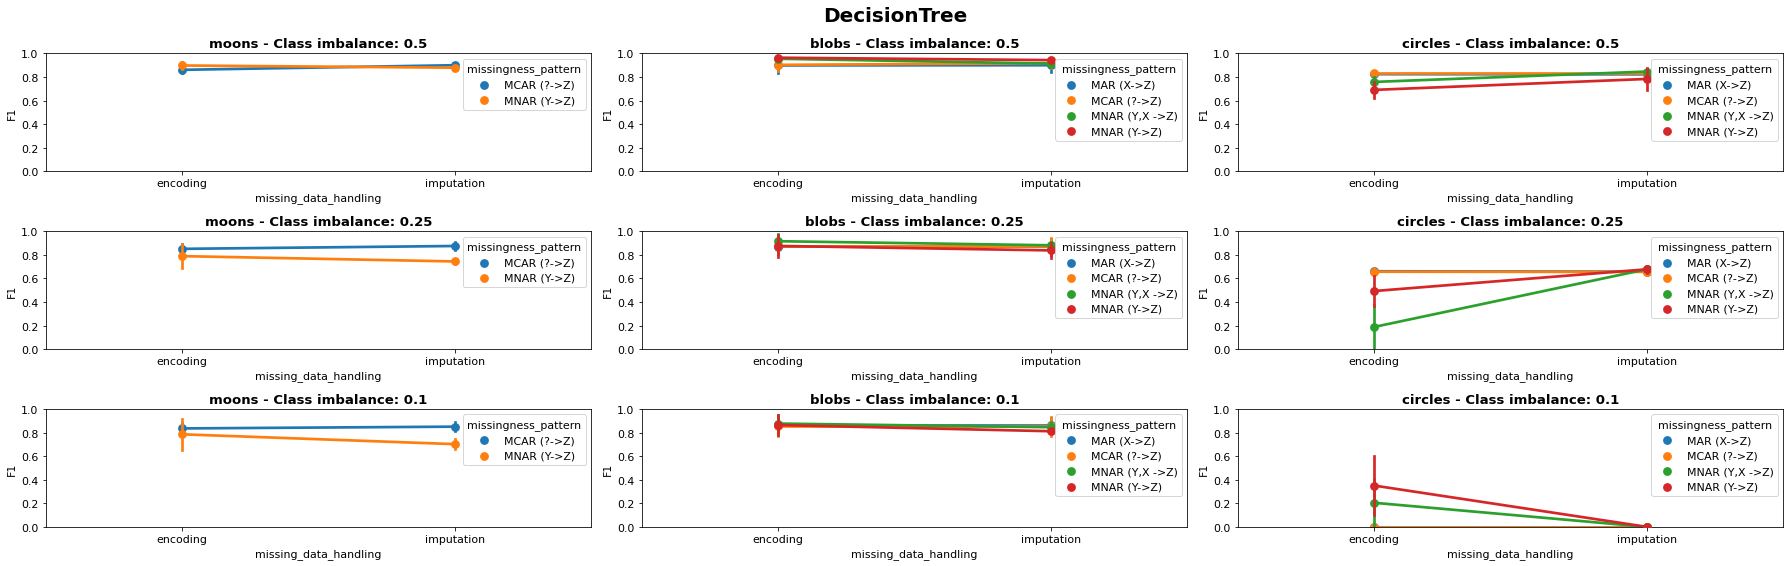

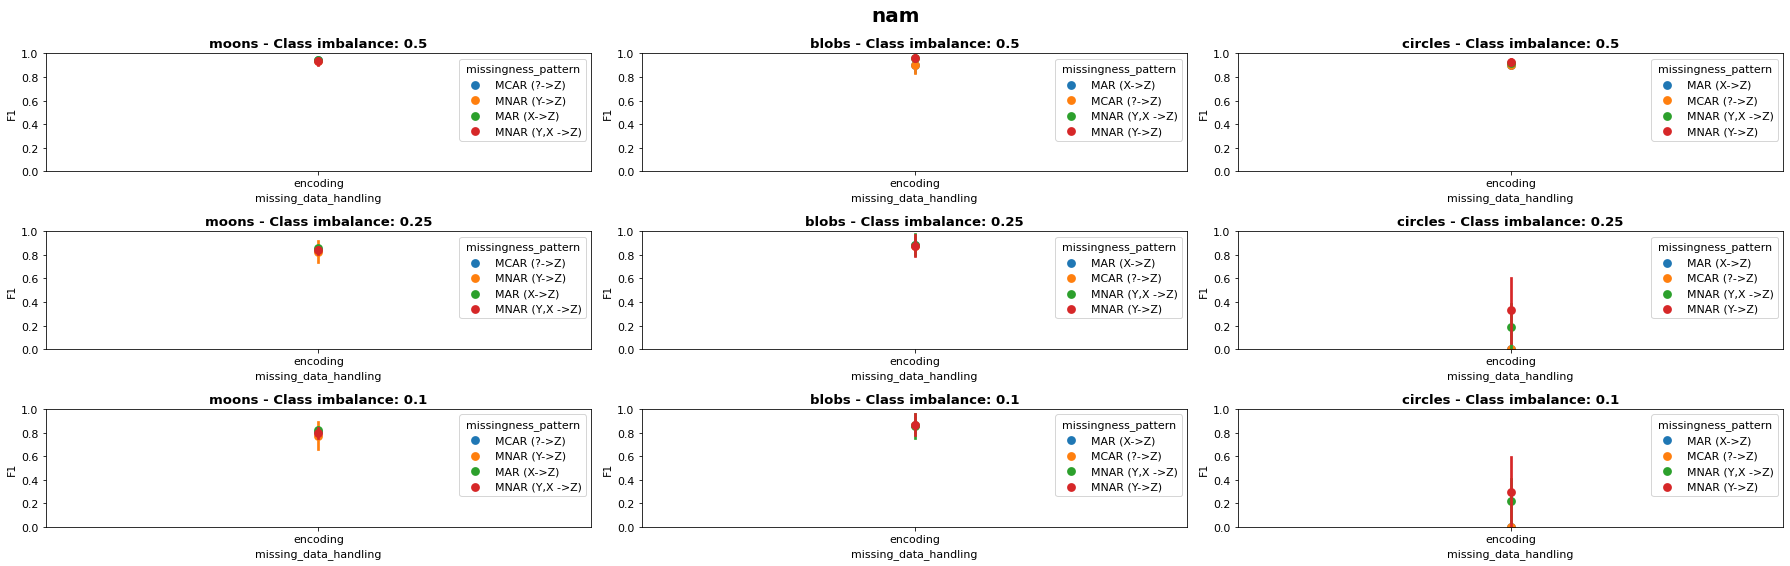

In [112]:
for approach in ['xgboost', 'ebm', 'LogisticRegression', 'DecisionTree', 'nam']:
    results = final_df[final_df['approach'] ==  approach]

    x = 'missing_data_handling'
    hue = 'missingness_pattern'


    fig, axes = plt.subplots(3, 3, figsize=(25, 8))
    fig.suptitle(approach, weight='bold', fontsize=20)

    for i, imbalance_ratio in enumerate(sorted(results['imbalance_ratio'].unique(), reverse=True)):

        for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):


            df = results[(results['imbalance_ratio']==imbalance_ratio) & (results['dataset_name']==dataset_name)]

            #assert check_unicity(df, x, hue)

            if len(df) > 0:

                axes[i][j] = sns.pointplot(data=df, x=x, y="F1", hue=hue, ci='sd', ax = axes[i][j])
                axes[i][j].set_ylim([0,1])
                axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
            else:
                axes[i][j].grid('off');axes[i][j].axis('off')

    plt.tight_layout()

# Result 1: comparison between approaches on the three dataset for different level of CI and MR 

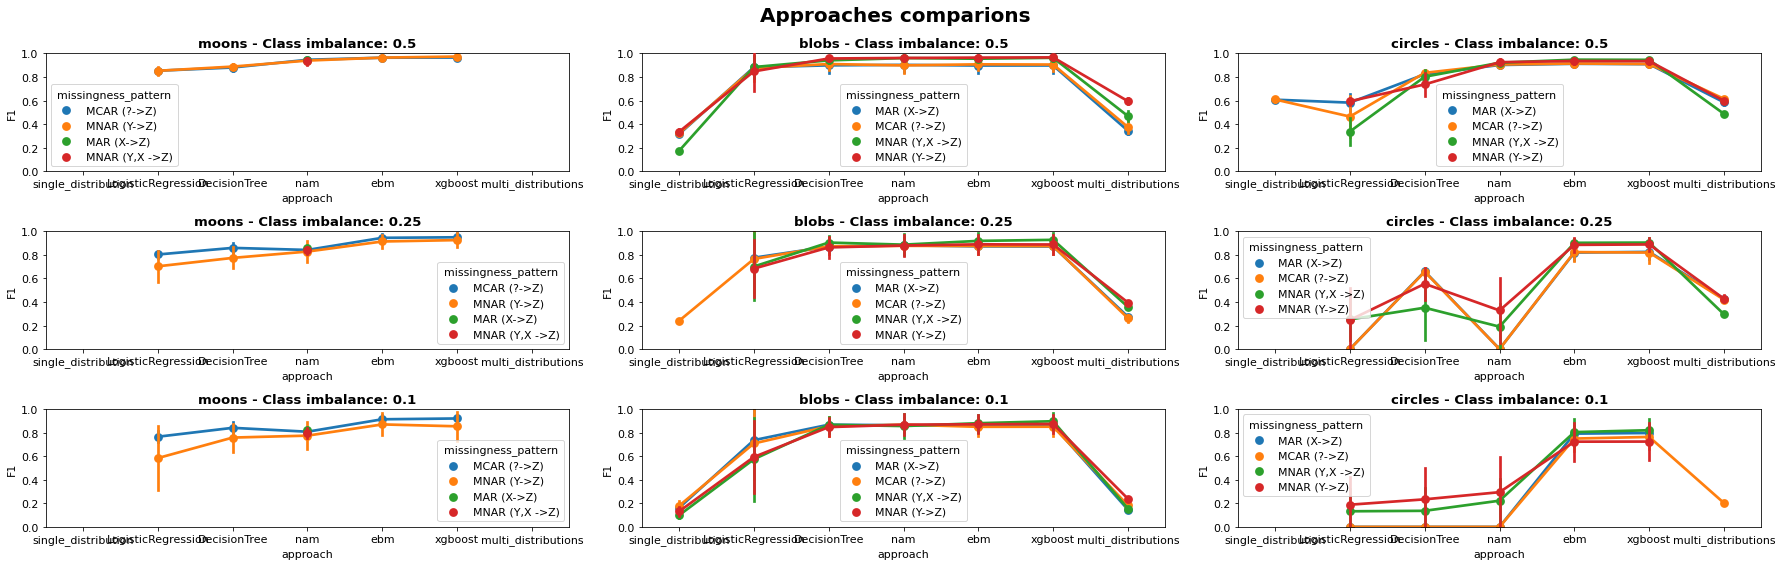

In [100]:
results = final_df#[final_df['approach'].isin(['single_distribution', 'multi_distributions'])]

x = 'approach'
hue = 'missingness_pattern'
    
    
fig, axes = plt.subplots(3, 3, figsize=(25, 8))
fig.suptitle("Approaches comparions", weight='bold', fontsize=20)

for i, imbalance_ratio in enumerate(sorted(results['imbalance_ratio'].unique(), reverse=True)):

    for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):


        df = results[(results['imbalance_ratio']==imbalance_ratio) & (results['dataset_name']==dataset_name)]

        #assert check_unicity(df, x, hue)

        if len(df) > 0:

            axes[i][j] = sns.pointplot(data=df, x=x, y="F1", hue=hue, order=['single_distribution', 'LogisticRegression', 'DecisionTree', 'nam', 'ebm', 'xgboost', 'multi_distributions'], ci='sd', ax = axes[i][j])
            axes[i][j].set_ylim([0,1])
            axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
        else:
            axes[i][j].grid('off');axes[i][j].axis('off')

plt.tight_layout()

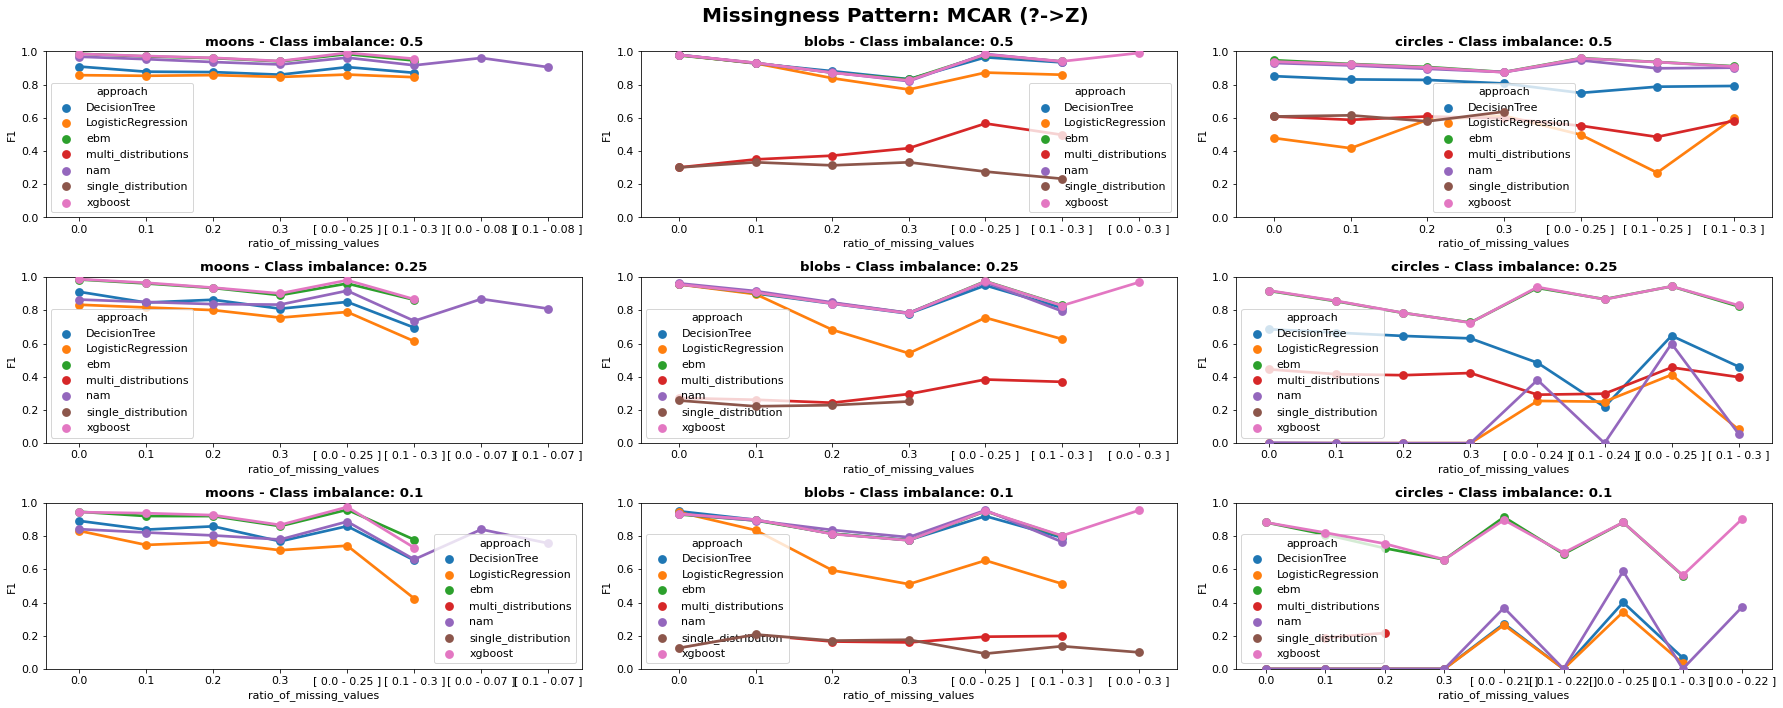

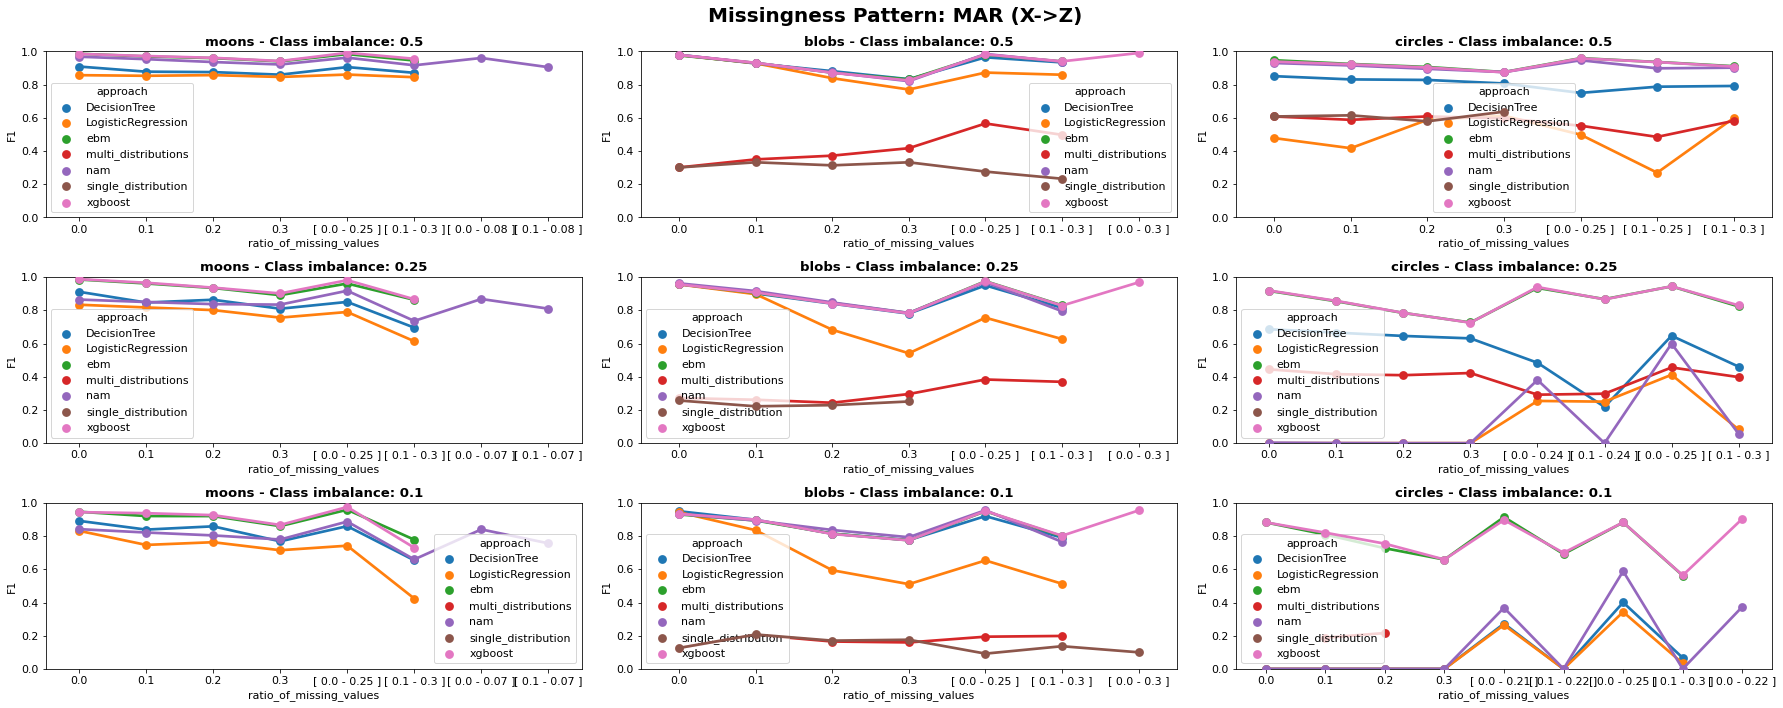

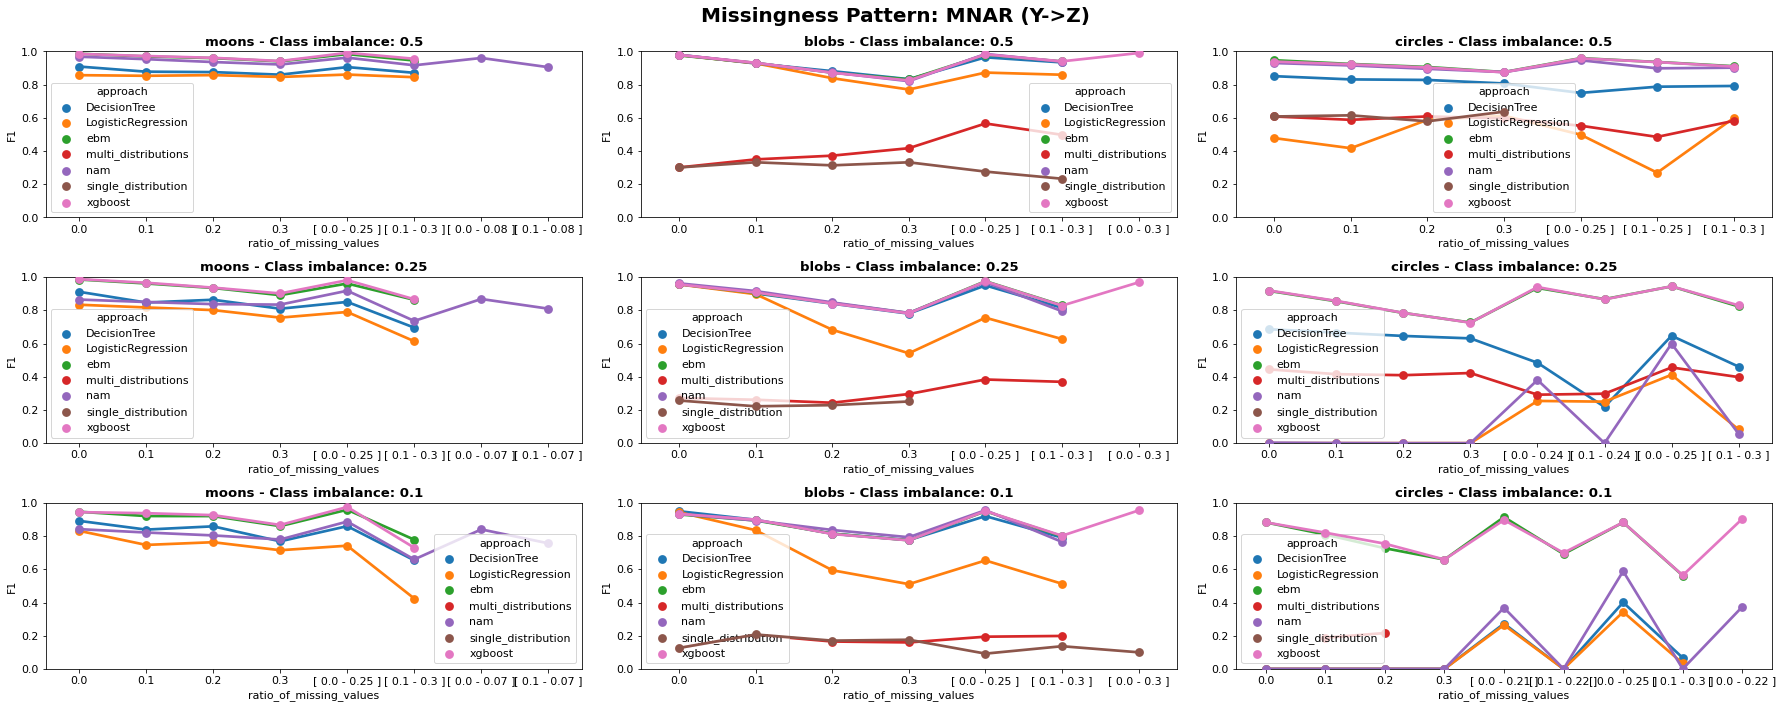

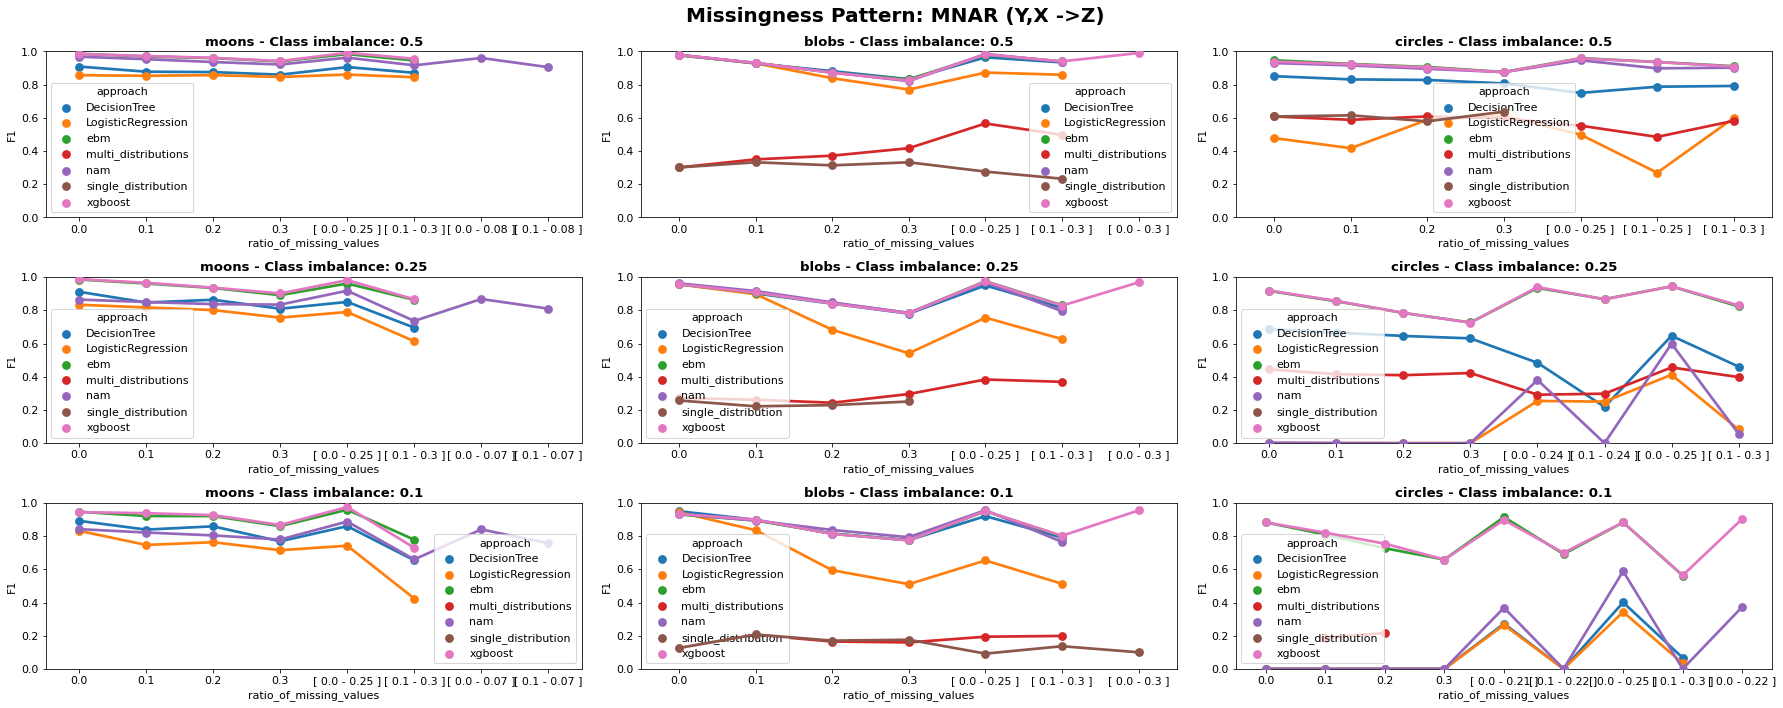

In [101]:
for missingness_pattern in [1, 3, 4, 5]:
    
    fig, axes = plt.subplots(3, 3, figsize=(25, 10))
    fig.suptitle("Missingness Pattern: {}".format(DICT_MISSINGNESS[missingness_pattern]), weight='bold', fontsize=20)

    for i, imbalance_ratio in enumerate(sorted(final_df['imbalance_ratio'].unique(), reverse=True)):

        for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):

            df = final_df[(final_df['imbalance_ratio']==imbalance_ratio) & (final_df['dataset_name']==dataset_name)]

            axes[i][j] = sns.pointplot(data=df, x="ratio_of_missing_values", y="F1", hue='approach', hue_order = final_df['approach'].unique(), ci=False, ax = axes[i][j])
            axes[i][j].set_ylim([0,1])
            axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
            
    plt.tight_layout()

# Results 2: How the different approaches are influence of the class imbalance and missing ratio

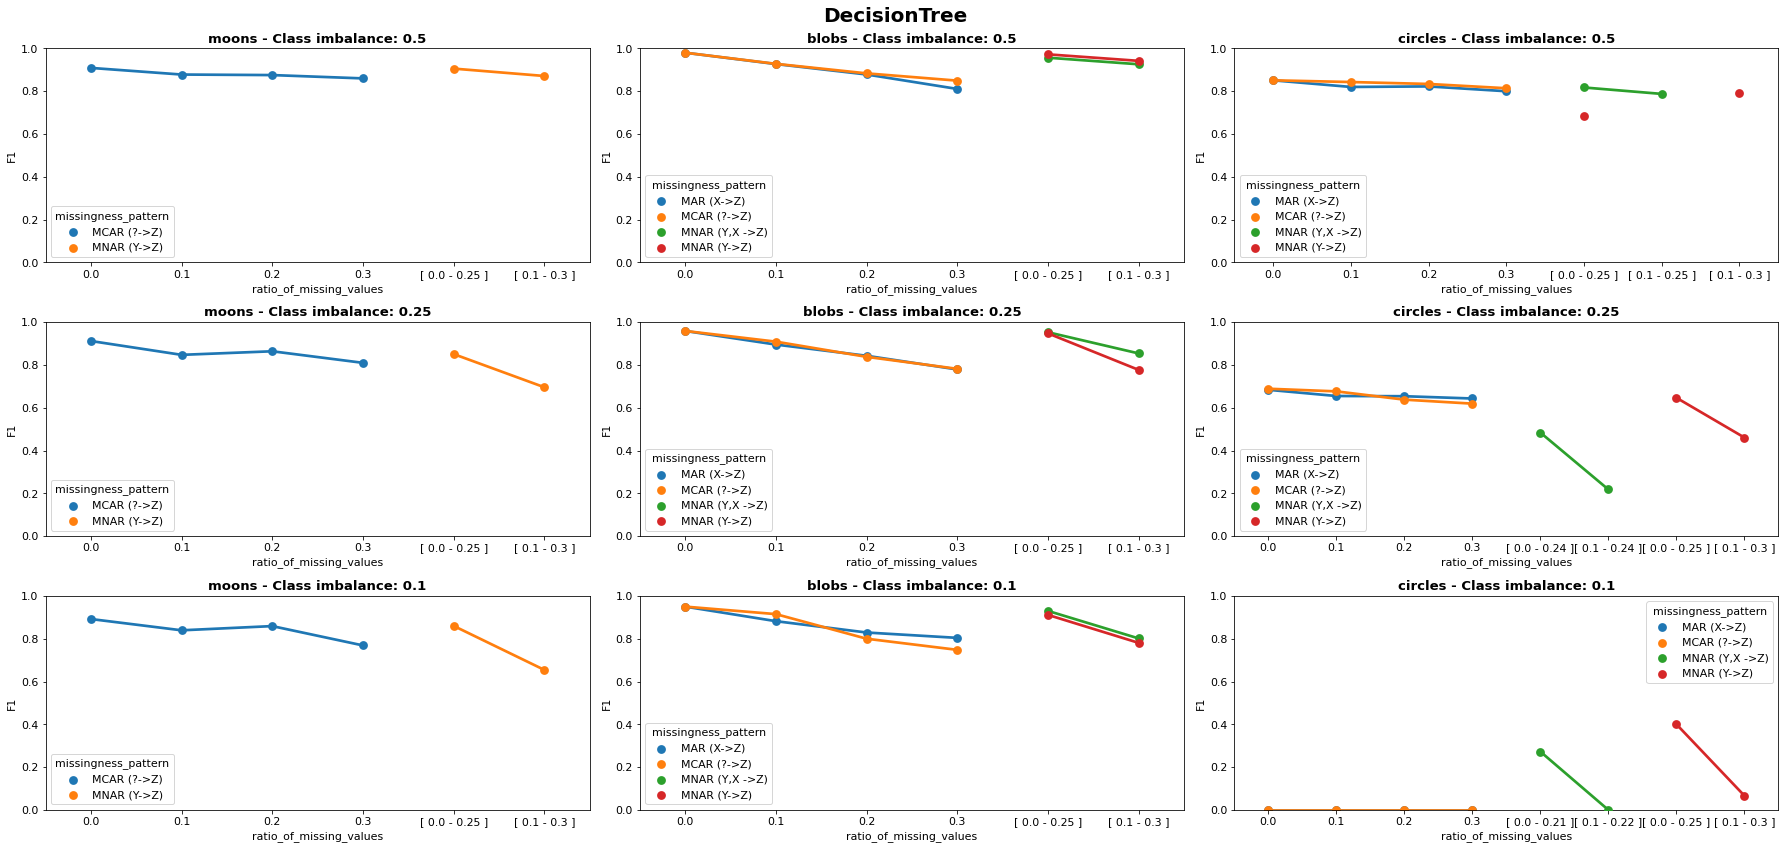

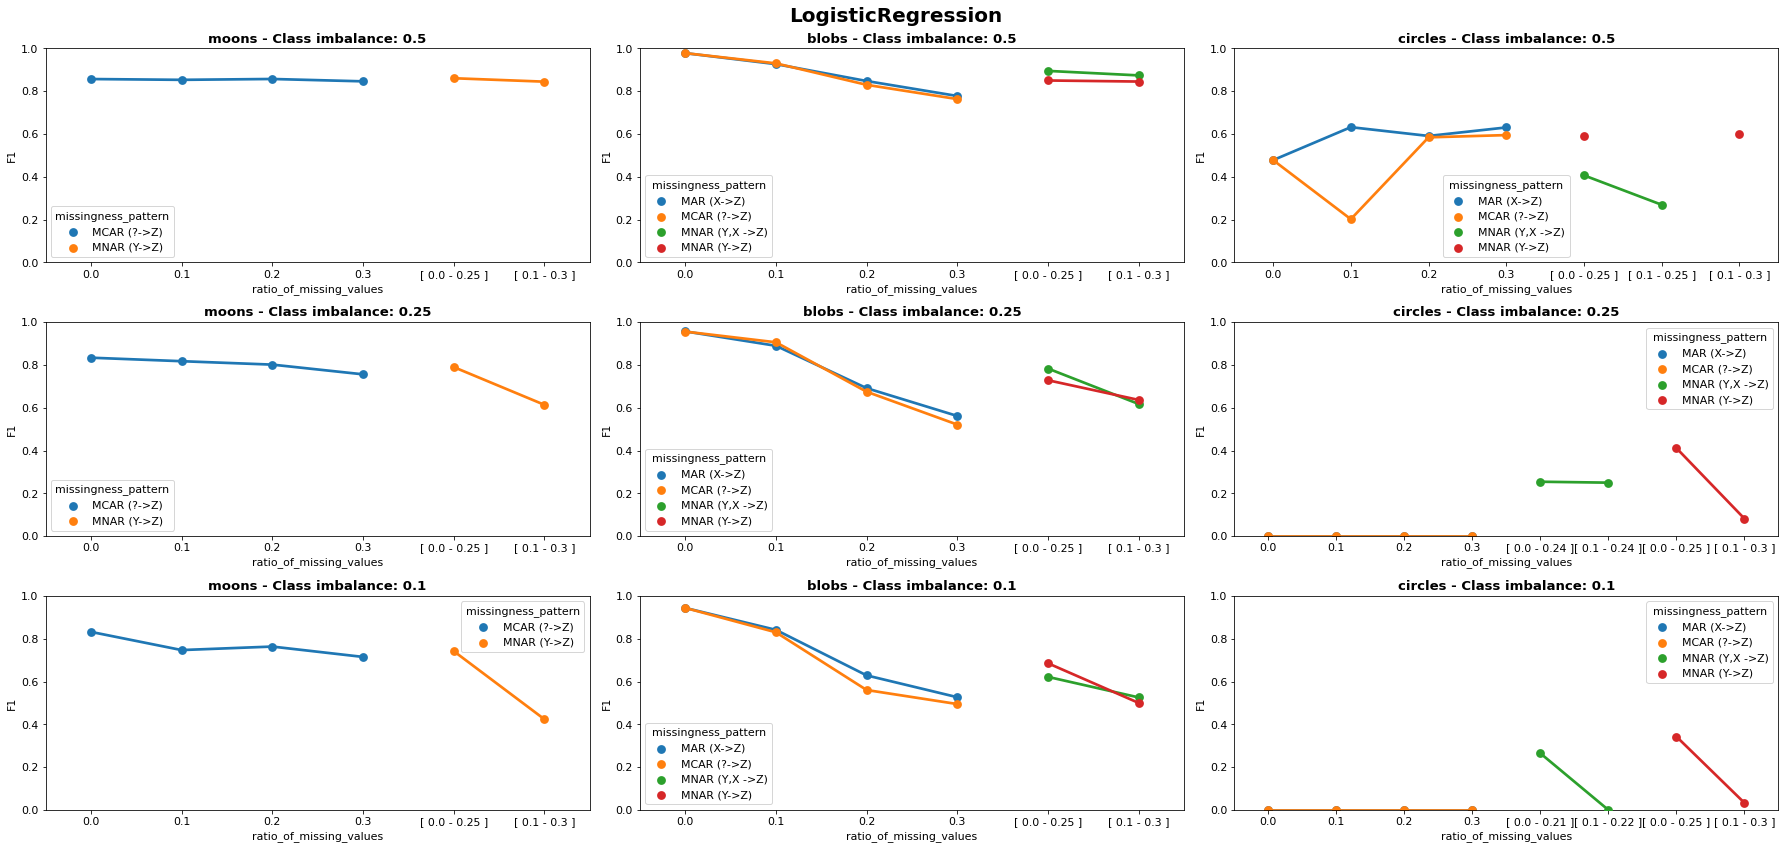

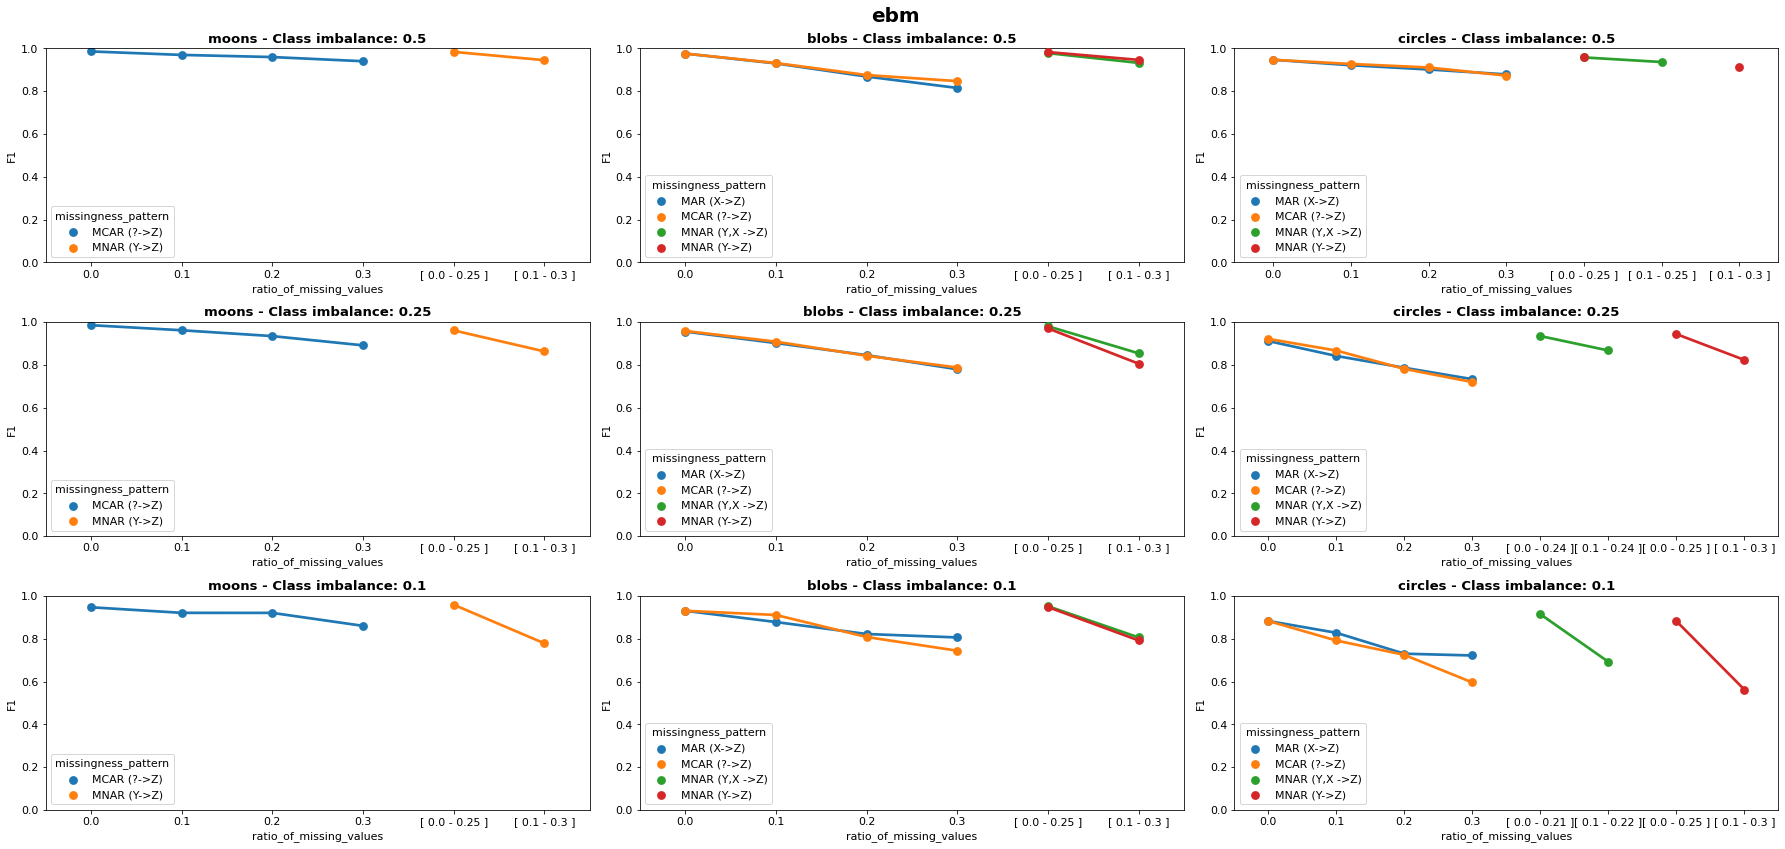

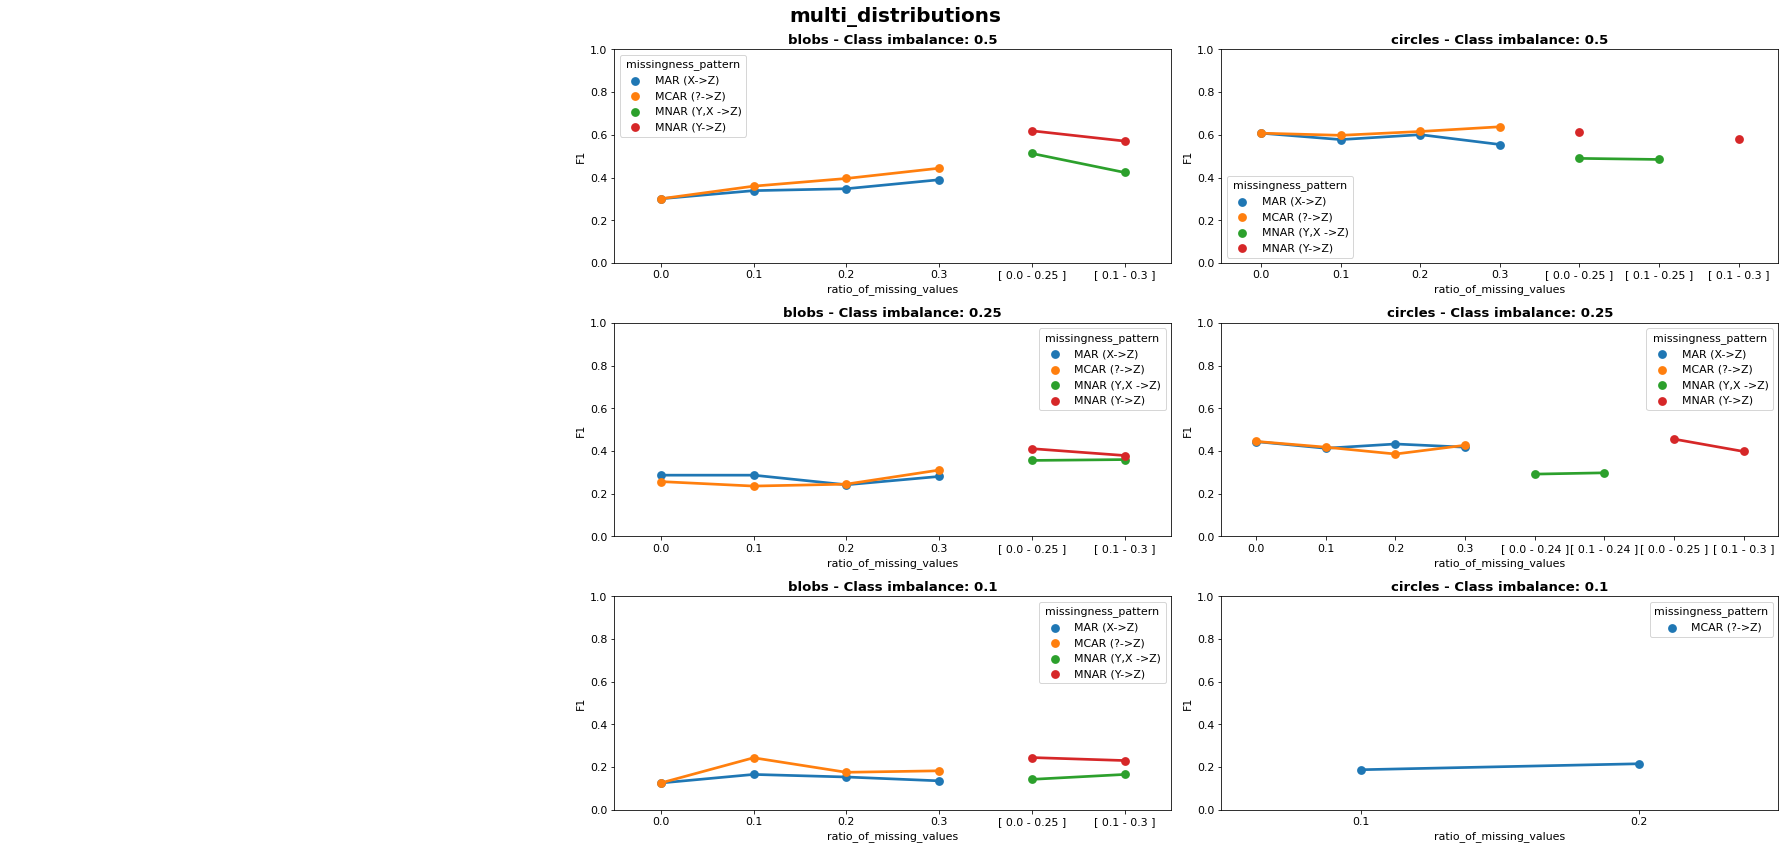

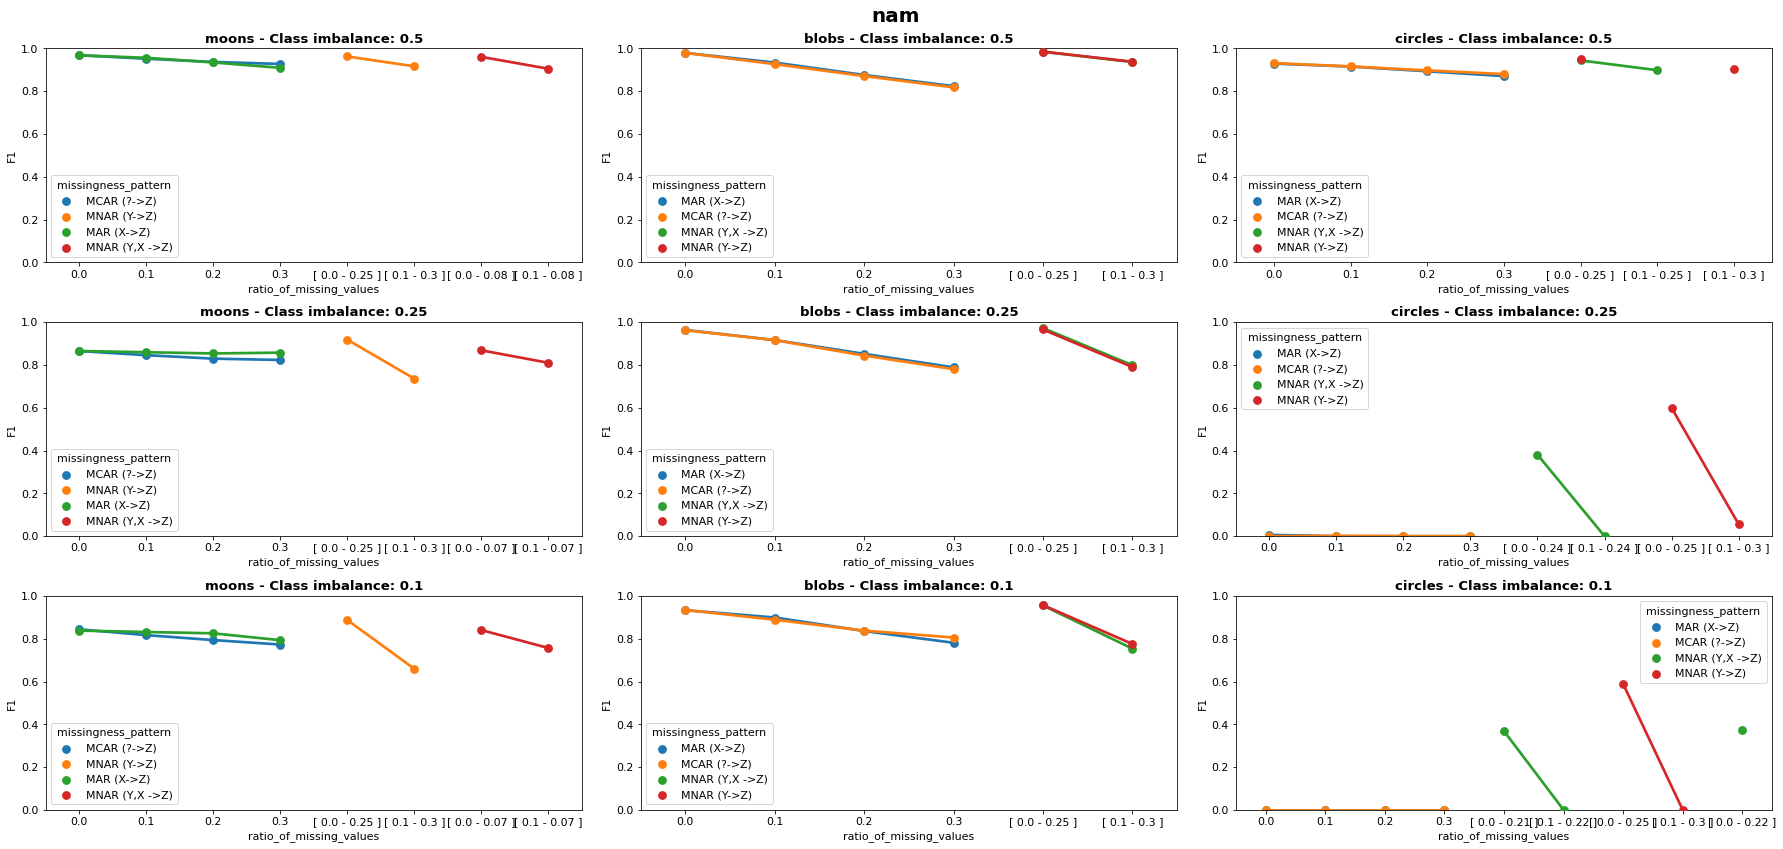

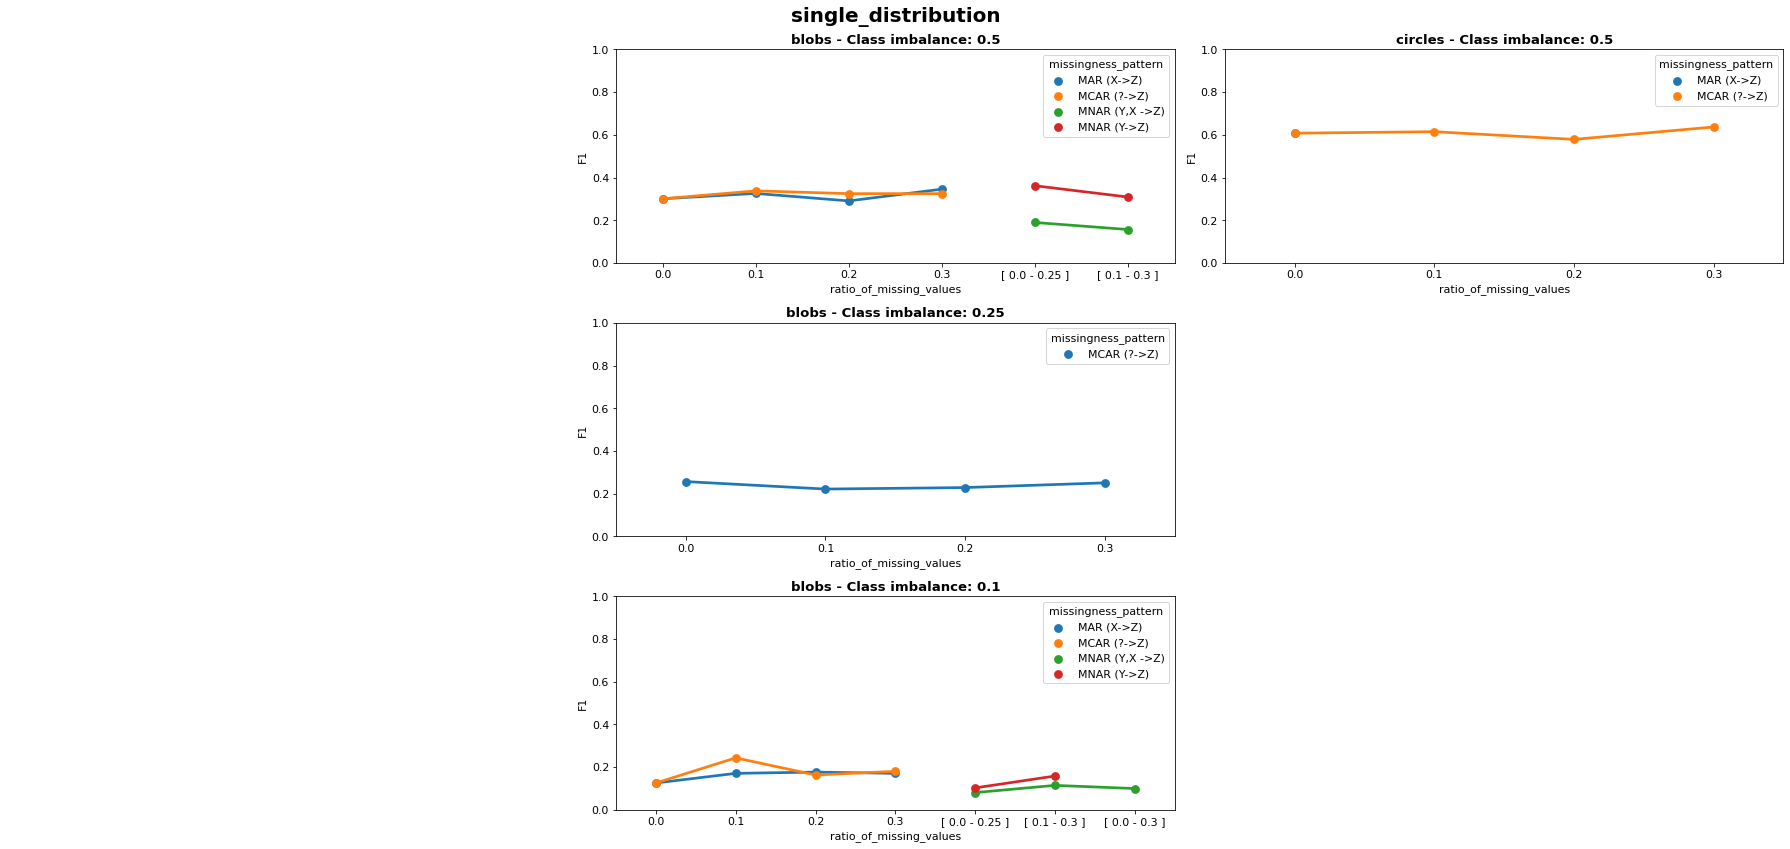

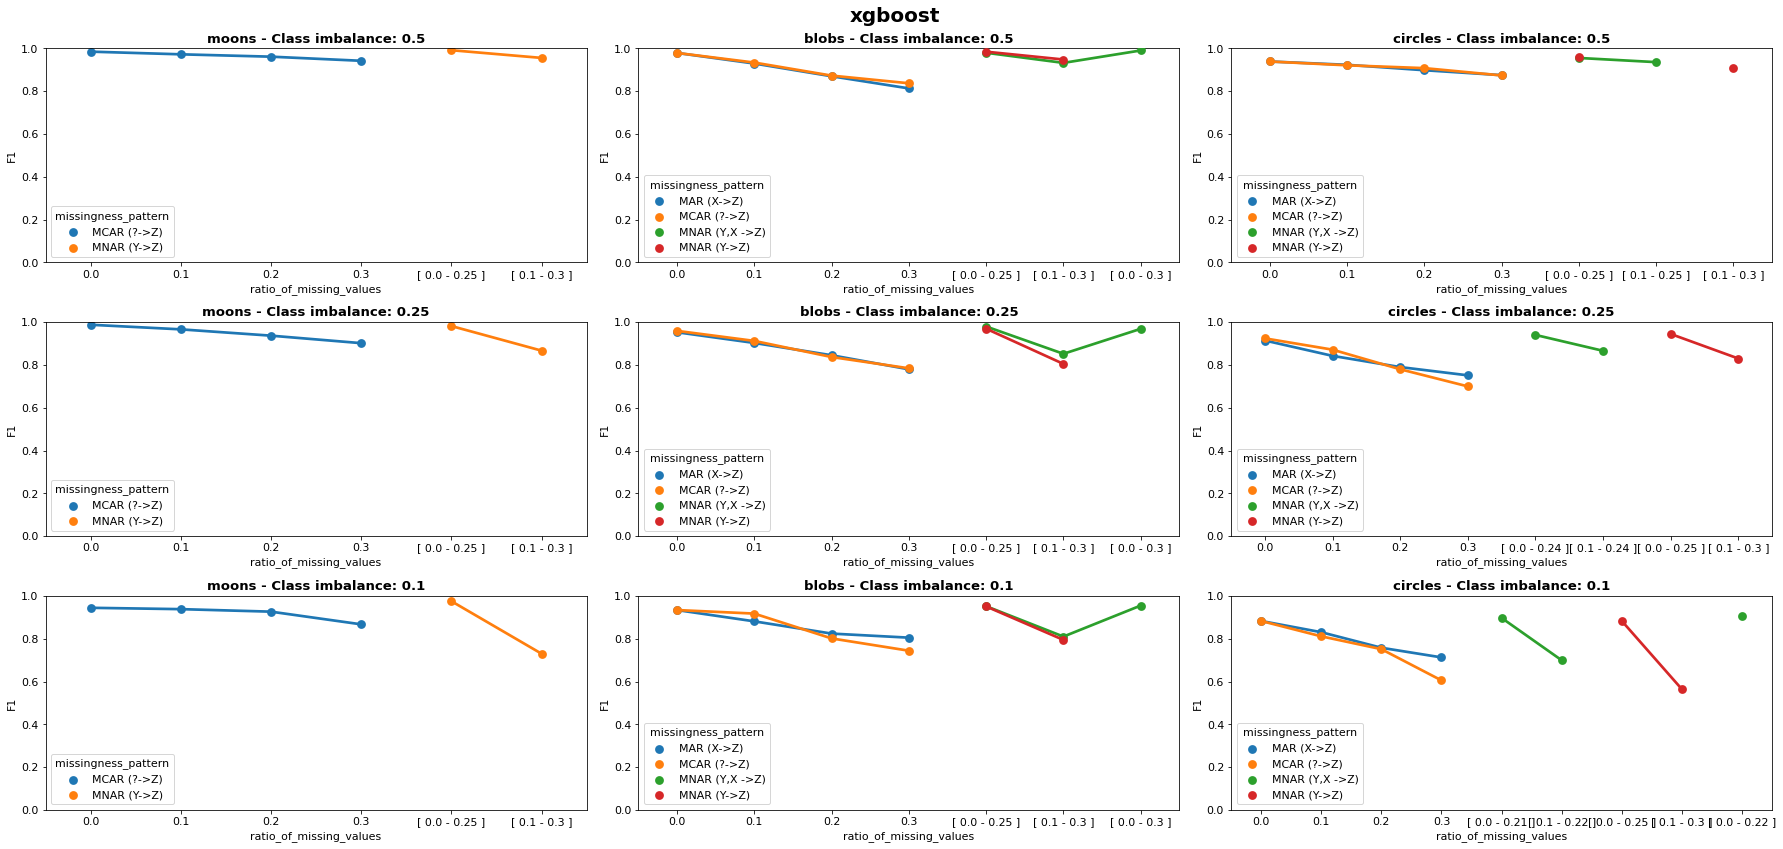

In [99]:
for approach in final_df['approach'].unique():
    fig, axes = plt.subplots(3, 3, figsize=(25, 12))
    fig.suptitle(approach, weight='bold', fontsize=20)

    for i, imbalance_ratio in enumerate(sorted(final_df['imbalance_ratio'].unique(), reverse=True)):

        for j, dataset_name in enumerate(['moons', 'blobs', 'circles']):

            df = final_df[(final_df['approach']==approach) & (final_df['imbalance_ratio']==imbalance_ratio) & (final_df['dataset_name']==dataset_name)]

            if len(df) > 1:

                axes[i][j] = sns.pointplot(data=df, x="ratio_of_missing_values", y="F1", hue='missingness_pattern', ci=False, ax = axes[i][j])
                axes[i][j].set_ylim([0,1])
                axes[i][j].set_title("{} - Class imbalance: {}".format(dataset_name, imbalance_ratio), weight='bold')
            else:
                axes[i][j].grid('off');axes[i][j].axis('off')

    plt.tight_layout()